# Marketing Mix using Random Forest and SHAP values

Slava Kisilevich
kisilevich.slava@gmail.com

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import math
import sys
import os


pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
import seaborn as sns

from plotnine import *


import plotly.io as pio
pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'


from IPython.core.debugger import set_trace

In [3]:
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [4]:
import shap
shap.initjs()

In [5]:
from sklearn.model_selection import TimeSeriesSplit

In [6]:
from prophet import Prophet

In [7]:
from functools import partial
import optuna as opt

In [8]:
START_ANALYSIS_INDEX = 52
END_ANALYSIS_INDEX = 144

## Data

In [9]:
data = pd.read_csv("./data/data_raw_2015-11-23__2019-11-11.csv", parse_dates = ["DATE"])
data.columns = [c.lower() if c in ["DATE"] else c for c in data.columns]
data

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000


In [10]:
holidays = pd.read_csv("./data/prophet_holidays_daily.csv", parse_dates = ["ds"])
holidays["begin_week"] = holidays["ds"].dt.to_period('W-SUN').dt.start_time
#combine same week holidays into one holiday
holidays_weekly = holidays.groupby(["begin_week", "country", "year"], as_index = False).agg({'holiday':'#'.join, 'country': 'first', 'year': 'first'}).rename(columns = {'begin_week': 'ds'})
holidays_weekly_de = holidays_weekly.query("(country == 'DE')").copy()
holidays_weekly_de

,ds,holiday,country,year
12,1994-12-26,Neujahr,DE,1995
183,1995-04-10,Karfreitag,DE,1995
222,1995-04-17,Ostermontag,DE,1995
270,1995-05-01,Erster Mai,DE,1995
346,1995-05-22,Christi Himmelfahrt,DE,1995
...,...,...,...,...
35445,2044-05-23,Christi Himmelfahrt,DE,2044
35481,2044-06-06,Pfingstmontag,DE,2044
35646,2044-10-03,Tag der Deutschen Einheit,DE,2044
35781,2044-12-19,Erster Weihnachtstag,DE,2044


In [11]:
prophet_data = data.rename(columns = {'revenue': 'y', 'date': 'ds'})
#add categorical into prophet
prophet_data = pd.concat([prophet_data, pd.get_dummies(prophet_data["events"], drop_first = True, prefix = "events")], axis = 1)
prophet_data

,ds,y,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,events_event2,events_na
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385,0,1
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000,0,1
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000,0,1
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000,0,1
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000,0,1
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000,0,1
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000,0,1
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000,0,1


In [12]:
prophet = Prophet(yearly_seasonality=True, holidays=holidays_weekly_de)
prophet.add_regressor(name = "events_event2")
prophet.add_regressor(name = "events_na")

In [13]:
prophet.fit(prophet_data[["ds", "y", "events_event2", "events_na"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y", "events_event2", "events_na"]])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


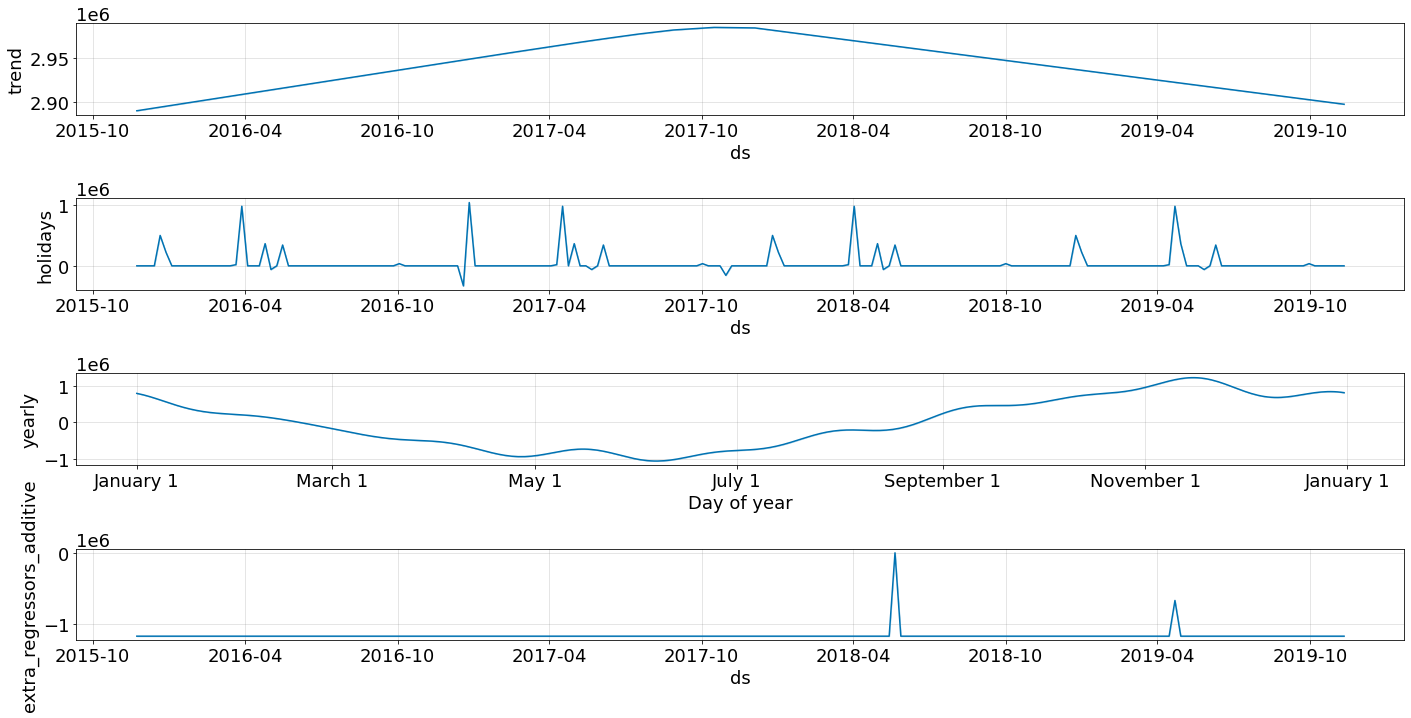

In [14]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [15]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)


final_data = data.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]
final_data["holiday"] = prophet_predict["holidays"]
final_data["events"] = (events_numeric - np.min(events_numeric)).values

## Non-linear parameter estimation

In [16]:
data.iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
52,2016-11-21,2964696.66667,52177.90000,271909,54698.00000,80485549.89262,0.00000,0,9029457,200462.81552,na,19401.65385
53,2016-11-28,2848525.00000,0.00000,0,31072.00000,53736753.49765,73955.95632,71500,9334174,141956.39115,na,27941.00000
54,2016-12-05,2740160.00000,106908.00000,448276,0.00000,21469926.03224,65123.98793,63000,8234498,49694.03594,na,51273.00000
55,2016-12-12,2380508.33333,0.00000,0,0.00000,29472934.60218,52768.86061,55100,7904539,90910.83720,na,19606.00000
56,2016-12-19,2230915.00000,0.00000,627975,0.00000,14122124.68989,47686.78427,51700,7127441,30356.33075,na,4453.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
139,2018-07-23,1479303.33333,72966.70000,0,38795.00000,0.00000,47370.36869,51900,4606123,0.00000,na,22477.00000
140,2018-07-30,1647193.33333,0.00000,0,0.00000,0.00000,77832.99757,58100,5494567,0.00000,na,8906.00000
141,2018-08-06,2009478.33333,97811.20000,173577,54001.00000,0.00000,76885.47655,65800,6045317,0.00000,na,59318.00000
142,2018-08-13,1523443.33333,0.00000,0,0.00000,54622076.09755,0.00000,0,5035305,133522.51163,na,19401.65385


In [17]:
data = final_data

In [18]:
target = "revenue"
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
features = ["trend", "season", "holiday", "competitor_sales_B", "events"] + media_channels + organic_channels

<AxesSubplot:>

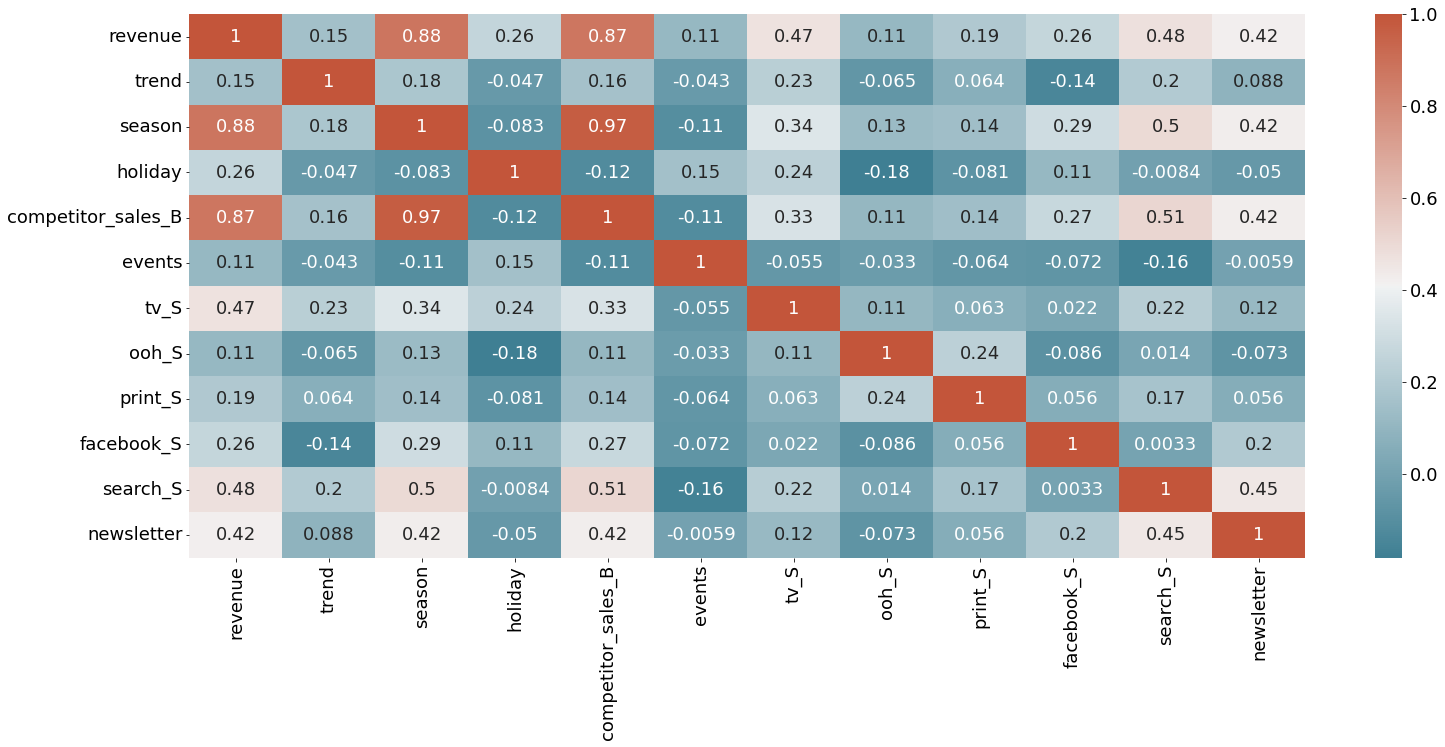

In [19]:
corr = data.loc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX - 1, [target] + features].corr()


fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = sns.diverging_palette(220, 20, as_cmap=True))

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted

class AdstockGeometric(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.5):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        return self
    
    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        x_decayed = np.zeros_like(X)
        x_decayed[0] = X[0]
        
        for xi in range(1, len(x_decayed)):
            x_decayed[xi] = X[xi] + self.alpha* x_decayed[xi - 1]
        return x_decayed
    
def nrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))

#https://github.com/facebookexperimental/Robyn
def rssd(effect_share, spend_share):
    """RSSD decomposition
    
    Decomposition distance (root-sum-square distance, a major innovation of Robyn) 
    eliminates the majority of "bad models" 
    (larger prediction error and/or unrealistic media effect like the smallest channel getting the most effect

    Args:
        effect_share ([type]): percentage of effect share
        spend_share ([type]): percentage of spend share

    Returns:
        [type]: [description]
    """
    return np.sqrt(np.sum((effect_share - spend_share) ** 2))


def plot_spend_vs_effect_share(decomp_spend: pd.DataFrame, figure_size = (15, 10)):
    """Spend vs Effect Share plot

    Args:
        decomp_spend (pd.DataFrame): Data with media decompositions. The following columns should be present: media, spend_share, effect_share per media variable
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).

    Example:
        decomp_spend:
        media         spend_share effect_share
        tv_S           0.31        0.44
        ooh_S          0.23        0.34
    
    Returns:
        [plotnine]: plotnine plot
    """
    
    plot_spend_effect_share = decomp_spend.melt(id_vars = ["media"], value_vars = ["spend_share", "effect_share"])

    plt = ggplot(plot_spend_effect_share, aes("media", "value", fill = "variable")) \
    + geom_bar(stat = "identity", position = "dodge") \
    + geom_text(aes(label = "value * 100", group = "variable"), color = "darkblue", position=position_dodge(width = 0.5), format_string = "{:.2f}%") \
    + coord_flip() \
    + ggtitle("Share of Spend VS Share of Effect") + ylab("") + xlab("") \
    + theme(figure_size = figure_size, 
                    legend_direction='vertical', 
                    legend_title=element_blank(),
                    legend_key_size=20, 
                    legend_entry_spacing_y=5) 
    return plt


def calculate_spend_effect_share(df_shap_values: pd.DataFrame, media_channels, df_original: pd.DataFrame):
    """
    Args:
        df_shap_values: data frame of shap values
        media_channels: list of media channel names
        df_original: non transformed original data
    Returns: 
        [pd.DataFrame]: data frame with spend effect shares
    """
    responses = pd.DataFrame(df_shap_values[media_channels].abs().sum(axis = 0), columns = ["effect_share"])
    response_percentages = responses / responses.sum()
    response_percentages

    spends_percentages = pd.DataFrame(df_original[media_channels].sum(axis = 0) / df_original[media_channels].sum(axis = 0).sum(), columns = ["spend_share"])
    spends_percentages

    spend_effect_share = pd.merge(response_percentages, spends_percentages, left_index = True, right_index = True)
    spend_effect_share = spend_effect_share.reset_index().rename(columns = {"index": "media"})
    
    return spend_effect_share


#https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
def shap_feature_importance(shap_values, data, figsize = (20, 10)):
    
    feature_list = data.columns
    
    if isinstance(shap_values, pd.DataFrame) == False:
        shap_v = pd.DataFrame(shap_values)
        shap_v.columns = feature_list
    else:
        shap_v = shap_values
    
        
    df_v = data.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=figsize,legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
def model_refit(data, 
                target, 
                features, 
                media_channels, 
                organic_channels, 
                model_params, 
                adstock_params, 
                start_index, 
                end_index):
    data_refit = data.copy()

    best_params = model_params

    adstock_alphas = adstock_params

    #apply adstock transformation
    for feature in media_channels + organic_channels:
        adstock_alpha = adstock_alphas[feature]
        print(f"applying geometric adstock transformation on {feature} with alpha {adstock_alpha}") 

        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_refit[feature] = temp_adstock

    #build the final model on the data until the end analysis index
    x_input = data_refit.loc[0:end_index-1, features]
    y_true_all = data[target].values[0:end_index]

    #build random forest using the best parameters
    random_forest = RandomForestRegressor(random_state=0, **best_params)
    random_forest.fit(x_input, y_true_all) 


    #concentrate on the analysis interval
    y_true_interval = y_true_all[start_index:end_index]
    x_input_interval_transformed = x_input.iloc[start_index:end_index]

    #revenue prediction for the analysis interval
    print(f"predicting {len(x_input_interval_transformed)}")
    prediction = random_forest.predict(x_input_interval_transformed)

    #transformed data set for the analysis interval 
    x_input_interval_nontransformed = data.iloc[start_index:end_index]


    #shap explainer 
    explainer = shap.TreeExplainer(random_forest)

    # get SHAP values for the data set for the analysis interval from explainer model
    shap_values_train = explainer.shap_values(x_input_interval_transformed)

    # create a dataframe of the shap values for the training set and the test set
    df_shap_values = pd.DataFrame(shap_values_train, columns=features)
    
    return {
            'df_shap_values': df_shap_values, 
            'x_input_interval_nontransformed': x_input_interval_nontransformed, 
            'x_input_interval_transformed' : x_input_interval_transformed,
            'prediction_interval': prediction, 
            'y_true_interval': y_true_interval
           }
    
def plot_shap_vs_spend(df_shap_values, x_input_interval_nontransformed, x_input_interval_transformed, features, media_channels, figsize=(25, 10)):
    for channel in media_channels:
    
        #index = features.index(channel)

        mean_spend = x_input_interval_nontransformed.loc[x_input_interval_nontransformed[channel] > 0, channel].mean()

        fig, ax = plt.subplots(figsize=figsize)
        sns.regplot(x = x_input_interval_transformed[channel], y = df_shap_values[channel], label = channel,
                    scatter_kws={'alpha': 0.65}, line_kws={'color': 'C2', 'linewidth': 6},
                    lowess=True, ax=ax).set(title=f'{channel}: Spend vs Shapley')
        ax.axhline(0, linestyle = "--", color = "black", alpha = 0.5)
        ax.axvline(mean_spend, linestyle = "--", color = "red", alpha = 0.5, label=f"Average Spend: {int(mean_spend)}")
        ax.set_xlabel(f"{channel} spend")
        ax.set_ylabel(f'SHAP Value for {channel}')
        plt.legend()

## Modeling with Random Forest

In [21]:
def optuna_trial(trial, 
                 data:pd.DataFrame, 
                 target, 
                 features, 
                 adstock_features, 
                 adstock_features_params, 
                 media_features, 
                 tscv, 
                 is_multiobjective = False):
    
    data_temp = data.copy()
    adstock_alphas = {}
    
    for feature in adstock_features:
        adstock_param = f"{feature}_adstock"
        min_, max_ = adstock_features_params[adstock_param]
        adstock_alpha = trial.suggest_uniform(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha
        
        #adstock transformation
        x_feature = data[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        data_temp[feature] = temp_adstock
        
        
    #Random Forest parameters
    n_estimators = trial.suggest_int("n_estimators", 5, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    max_depth = trial.suggest_int("max_depth", 4,7)
    ccp_alpha = trial.suggest_uniform("ccp_alpha", 0, 0.3)
    bootstrap = trial.suggest_categorical("bootstrap", [False, True])
    criterion = trial.suggest_categorical("criterion", ["squared_error"])  #"absolute_error"
    
    scores = []
    
    rssds = []
    for train_index, test_index in tscv.split(data_temp):
        x_train = data_temp.iloc[train_index][features]
        y_train =  data_temp[target].values[train_index]
        
        x_test = data_temp.iloc[test_index][features]
        y_test = data_temp[target].values[test_index]
        
        #apply Random Forest
        params = {"n_estimators": n_estimators, 
                   "min_samples_leaf":min_samples_leaf, 
                   "min_samples_split" : min_samples_split,
                   "max_depth" : max_depth, 
                   "ccp_alpha" : ccp_alpha, 
                   "bootstrap" : bootstrap, 
                   "criterion" : criterion
                 }
        
        rf = RandomForestRegressor(random_state=0, **params)
        rf.fit(x_train, y_train)
        prediction = rf.predict(x_test)
        
        rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
        scores.append(rmse)
        
        if is_multiobjective:
            
            #set_trace()
            #calculate spend effect share -> rssd
            # create explainer model by passing trained model to shap
            explainer = shap.TreeExplainer(rf)

            # get Shap values
            shap_values_train = explainer.shap_values(x_train)
            
            df_shap_values = pd.DataFrame(shap_values_train, columns=features)

            spend_effect_share = calculate_spend_effect_share(df_shap_values = df_shap_values, media_channels = media_features, df_original = data.iloc[train_index])

            decomp_rssd = rssd(effect_share = spend_effect_share.effect_share.values, spend_share = spend_effect_share.spend_share.values)
            rssds.append(decomp_rssd)
    
    trial.set_user_attr("scores", scores)
    
    trial.set_user_attr("params", params)
    trial.set_user_attr("adstock_alphas", adstock_alphas)
    
    if is_multiobjective == False:
        return np.mean(scores)
    
    
    trial.set_user_attr("rssds", rssds)
        
    #multiobjective
    return np.mean(scores), np.mean(rssds)

In [22]:
def optuna_optimize(trials, 
                    data: pd.DataFrame, 
                    target, 
                    features, 
                    adstock_features, 
                    adstock_features_params, 
                    media_features, 
                    tscv, 
                    is_multiobjective, 
                    seed = 42):
    print(f"data size: {len(data)}")
    print(f"media features: {media_features}")
    print(f"adstock features: {adstock_features}")
    print(f"features: {features}")
    print(f"is_multiobjective: {is_multiobjective}")
    opt.logging.set_verbosity(opt.logging.WARNING) 
    
    if is_multiobjective == False:
        study_mmm = opt.create_study(direction='minimize', sampler = opt.samplers.TPESampler(seed=seed))  
    else:
        study_mmm = opt.create_study(directions=["minimize", "minimize"], sampler=opt.samplers.NSGAIISampler(seed=seed))
        
    optimization_function = partial(optuna_trial, 
                                    data = data, 
                                    target = target, 
                                    features = features, 
                                    adstock_features = adstock_features, 
                                    adstock_features_params = adstock_features_params, 
                                    media_features = media_features, 
                                    tscv = tscv, 
                                    is_multiobjective = is_multiobjective)
    
    
    study_mmm.optimize(optimization_function, n_trials = trials, show_progress_bar = True)
    
    return study_mmm
    

In [23]:
tscv = TimeSeriesSplit(n_splits=3, test_size = 20)

adstock_features_params = {}
adstock_features_params["tv_S_adstock"] = (0.3, 0.8)
adstock_features_params["ooh_S_adstock"] = (0.1, 0.4)
adstock_features_params["print_S_adstock"] = (0.1, 0.4)
adstock_features_params["facebook_S_adstock"] = (0.0, 0.4)
adstock_features_params["search_S_adstock"] = (0.0, 0.3)
adstock_features_params["newsletter_adstock"] = (0.1, 0.4)

OPTUNA_TRIALS = 2000
experiment = optuna_optimize(trials = OPTUNA_TRIALS, 
                             data = data, 
                             target = target, 
                             features = features, 
                             adstock_features = media_channels + organic_channels, 
                             adstock_features_params = adstock_features_params, 
                             media_features=media_channels, 
                             tscv = tscv, 
                             is_multiobjective=False)

data size: 208
media features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
adstock features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
features: ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
is_multiobjective: False


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
experiment

In [25]:
experiment.best_trial.user_attrs["scores"]

[162390.01010327024, 114089.35799374945, 79415.8649240292]

In [26]:
experiment.best_trial.user_attrs["params"]

{'n_estimators': 17,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'max_depth': 7,
 'ccp_alpha': 0.19951653203058856,
 'bootstrap': True,
 'criterion': 'squared_error'}

In [27]:
experiment.best_trial.user_attrs["adstock_alphas"]

{'tv_S': 0.5343389820427953,
 'ooh_S': 0.21179063584028718,
 'print_S': 0.27877433150946473,
 'facebook_S': 0.3447366707231967,
 'search_S': 0.11609804659096469,
 'newsletter': 0.2559060243894163}

In [28]:
experiment.best_params

{'adstock_alpha_tv_S': 0.5343389820427953,
 'adstock_alpha_ooh_S': 0.21179063584028718,
 'adstock_alpha_print_S': 0.27877433150946473,
 'adstock_alpha_facebook_S': 0.3447366707231967,
 'adstock_alpha_search_S': 0.11609804659096469,
 'adstock_alpha_newsletter': 0.2559060243894163,
 'n_estimators': 17,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'max_depth': 7,
 'ccp_alpha': 0.19951653203058856,
 'bootstrap': True,
 'criterion': 'squared_error'}

In [29]:
experiment.best_trial

FrozenTrial(number=1877, values=[118631.74434034963], datetime_start=datetime.datetime(2022, 6, 8, 18, 34, 7, 470925), datetime_complete=datetime.datetime(2022, 6, 8, 18, 34, 8, 132181), params={'adstock_alpha_tv_S': 0.5343389820427953, 'adstock_alpha_ooh_S': 0.21179063584028718, 'adstock_alpha_print_S': 0.27877433150946473, 'adstock_alpha_facebook_S': 0.3447366707231967, 'adstock_alpha_search_S': 0.11609804659096469, 'adstock_alpha_newsletter': 0.2559060243894163, 'n_estimators': 17, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_depth': 7, 'ccp_alpha': 0.19951653203058856, 'bootstrap': True, 'criterion': 'squared_error'}, distributions={'adstock_alpha_tv_S': UniformDistribution(high=0.8, low=0.3), 'adstock_alpha_ooh_S': UniformDistribution(high=0.4, low=0.1), 'adstock_alpha_print_S': UniformDistribution(high=0.4, low=0.1), 'adstock_alpha_facebook_S': UniformDistribution(high=0.4, low=0.0), 'adstock_alpha_search_S': UniformDistribution(high=0.3, low=0.0), 'adstock_alpha_newslette

In [30]:
np.mean(experiment.best_trial.user_attrs["scores"])

118631.74434034963

In [31]:
experiment.best_trial.user_attrs["params"]

{'n_estimators': 17,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'max_depth': 7,
 'ccp_alpha': 0.19951653203058856,
 'bootstrap': True,
 'criterion': 'squared_error'}

In [32]:
experiment.best_trial.user_attrs["adstock_alphas"]

{'tv_S': 0.5343389820427953,
 'ooh_S': 0.21179063584028718,
 'print_S': 0.27877433150946473,
 'facebook_S': 0.3447366707231967,
 'search_S': 0.11609804659096469,
 'newsletter': 0.2559060243894163}

## Model Refit

In [33]:
best_params = experiment.best_trial.user_attrs["params"]
adstock_params = experiment.best_trial.user_attrs["adstock_alphas"]
result = model_refit(data = data, 
                     target = target,
                     features = features, 
                     media_channels = media_channels, 
                     organic_channels = organic_channels, 
                     model_params = best_params, 
                     adstock_params = adstock_params, 
                     start_index = START_ANALYSIS_INDEX, 
                     end_index = END_ANALYSIS_INDEX)

applying geometric adstock transformation on tv_S with alpha 0.5343389820427953
applying geometric adstock transformation on ooh_S with alpha 0.21179063584028718
applying geometric adstock transformation on print_S with alpha 0.27877433150946473
applying geometric adstock transformation on facebook_S with alpha 0.3447366707231967
applying geometric adstock transformation on search_S with alpha 0.11609804659096469
applying geometric adstock transformation on newsletter with alpha 0.2559060243894163
predicting 92


## Metrics

RMSE: 147281.7518117023
MAPE: 0.03970734257147562
NRMSE: 0.04779937735572616
R2: 0.9614825413186093


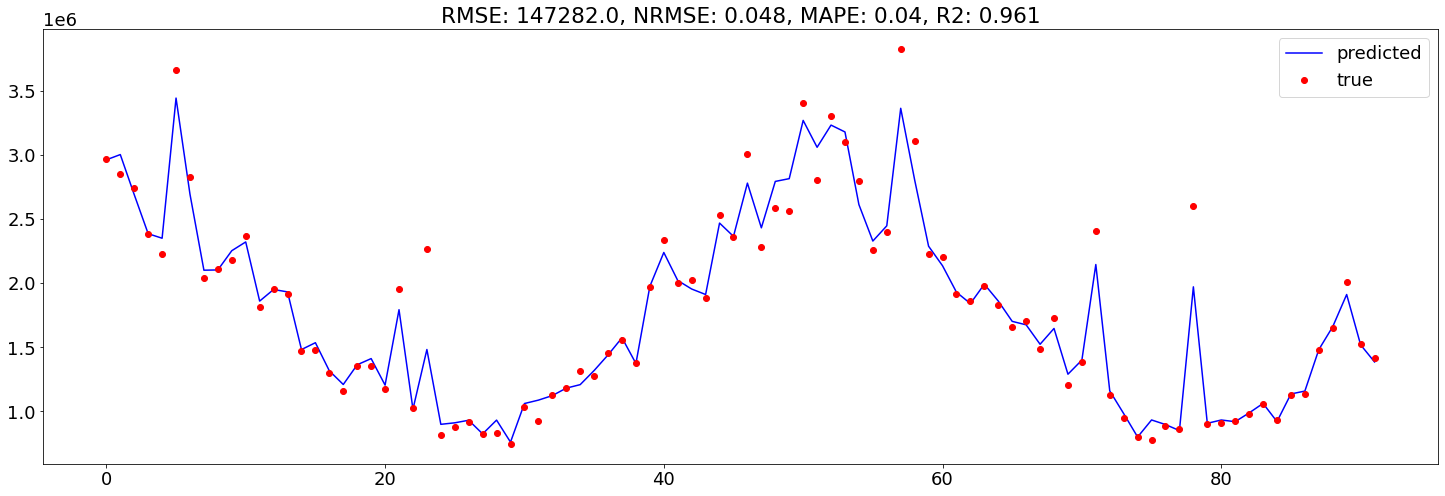

In [45]:
rmse_metric = mean_squared_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"], squared=False)
mape_metric = mean_absolute_percentage_error(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])
nrmse_metric = nrmse(result["y_true_interval"], result["prediction_interval"])
r2_metric = r2_score(y_true = result["y_true_interval"], y_pred = result["prediction_interval"])

print(f'RMSE: {rmse_metric}')
print(f'MAPE: {mape_metric}')
print(f'NRMSE: {nrmse_metric}')
print(f'R2: {r2_metric}')


fig, ax = plt.subplots(figsize = (25, 8))
_ = ax.plot(result["prediction_interval"], color = "blue", label = "predicted")
_ = ax.plot(result["y_true_interval"], 'ro', label = "true")
_ = plt.title(f"RMSE: {np.round(rmse_metric)}, NRMSE: {np.round(nrmse_metric, 3)}, MAPE: {np.round(mape_metric, 3)}, R2: {np.round(r2_metric,3)}")
_ = ax.legend()

## Feature Importance

invalid value encountered in true_divide
invalid value encountered in true_divide


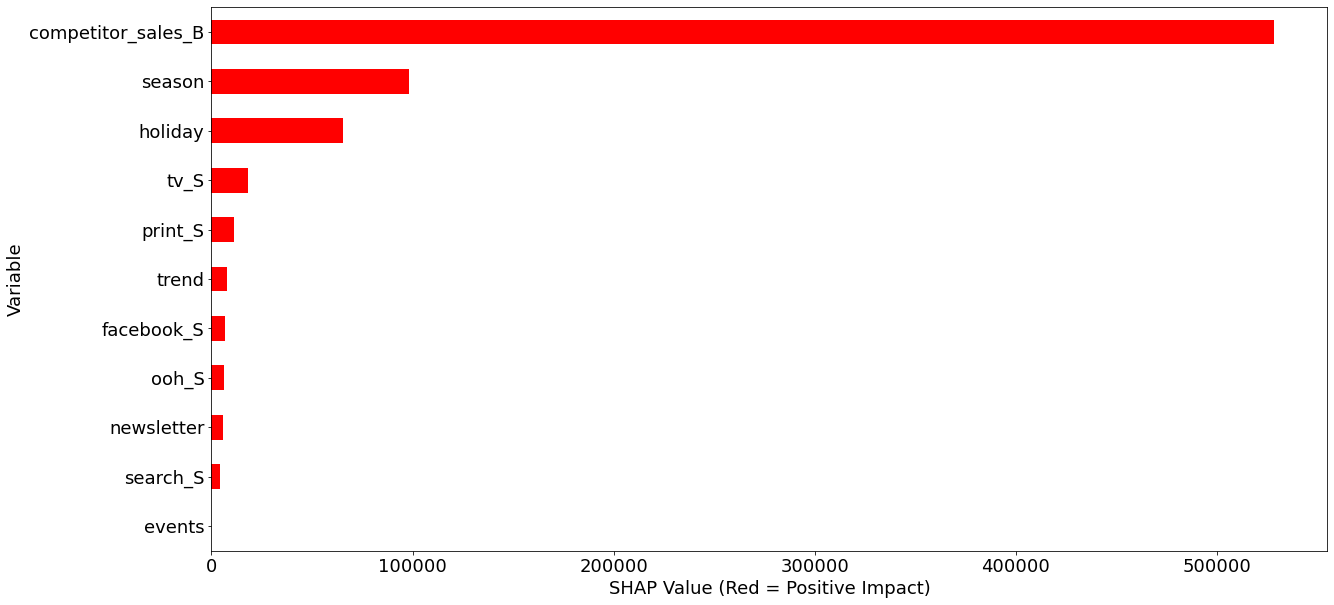

In [35]:
shap_feature_importance(result["df_shap_values"], result["x_input_interval_transformed"])

DECOMP.RSSD: 0.2534602765217651


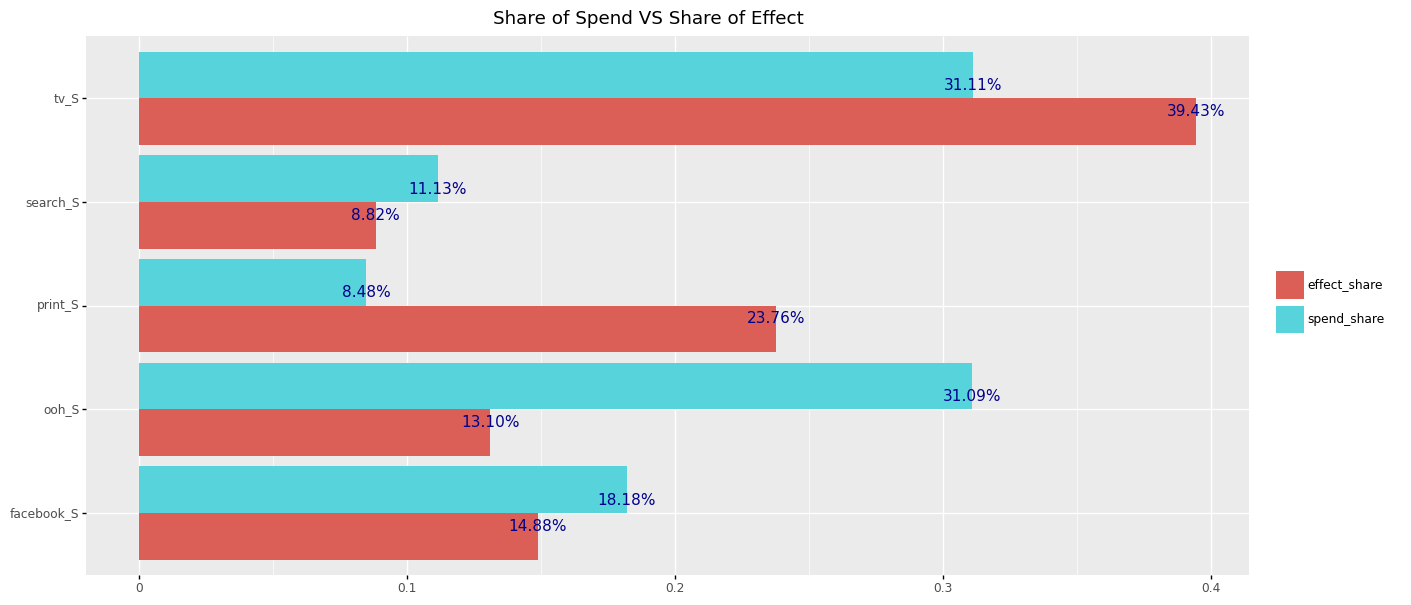

In [36]:
spend_effect_share = calculate_spend_effect_share(df_shap_values = result["df_shap_values"], media_channels = media_channels, df_original = result["x_input_interval_nontransformed"])

decomp_rssd = rssd(effect_share = spend_effect_share.effect_share.values, spend_share = spend_effect_share.spend_share.values)
print(f"DECOMP.RSSD: {decomp_rssd}")
print(plot_spend_vs_effect_share(spend_effect_share, figure_size = (15, 7)))



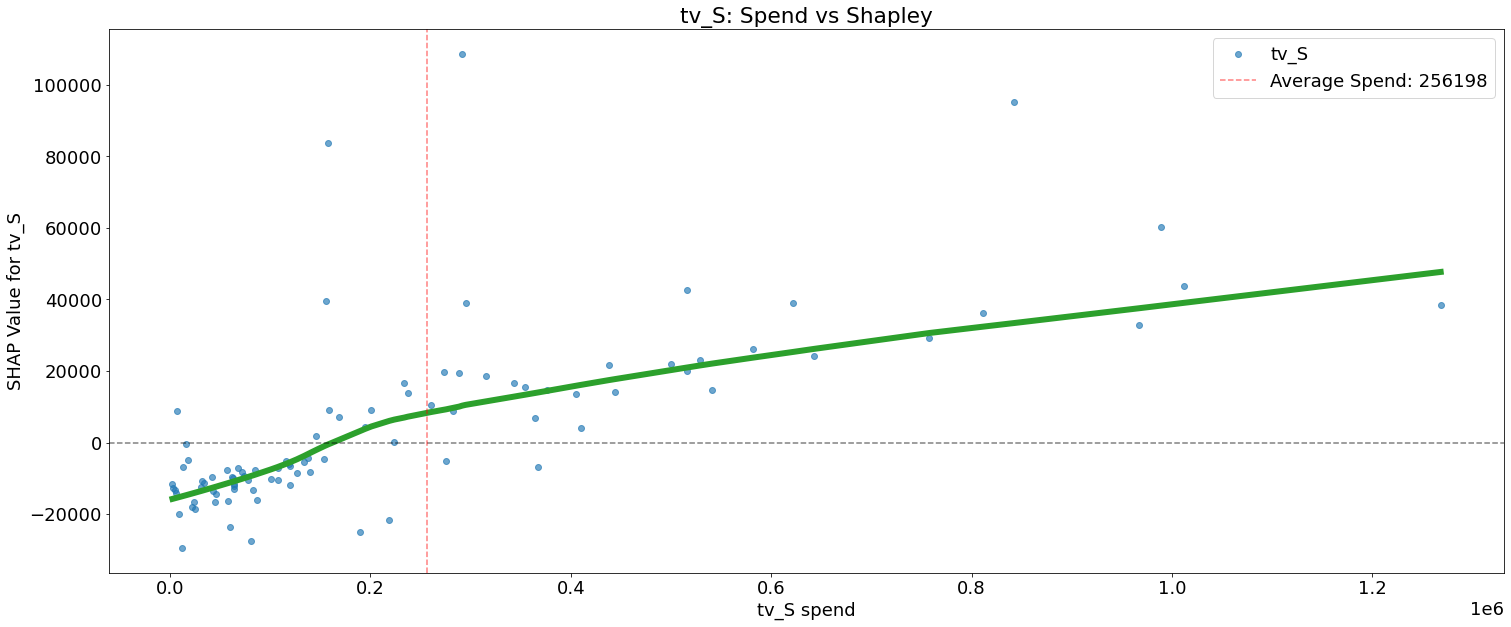

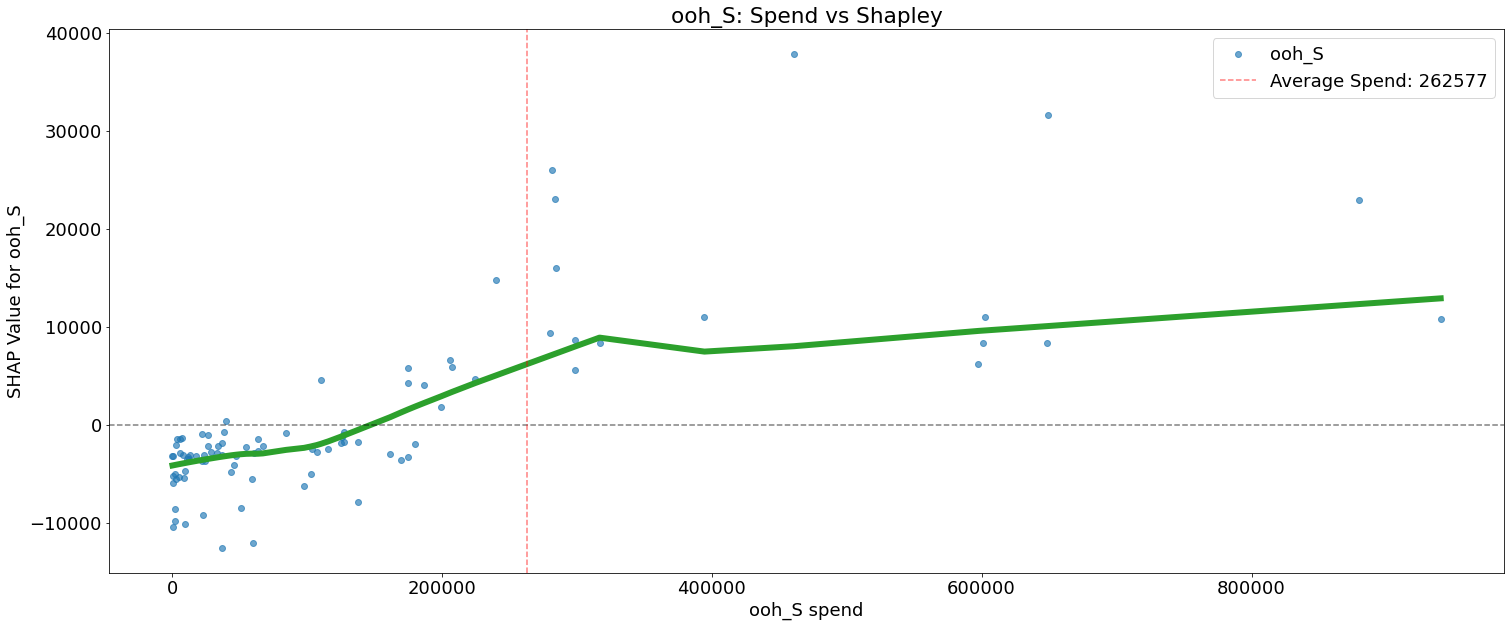

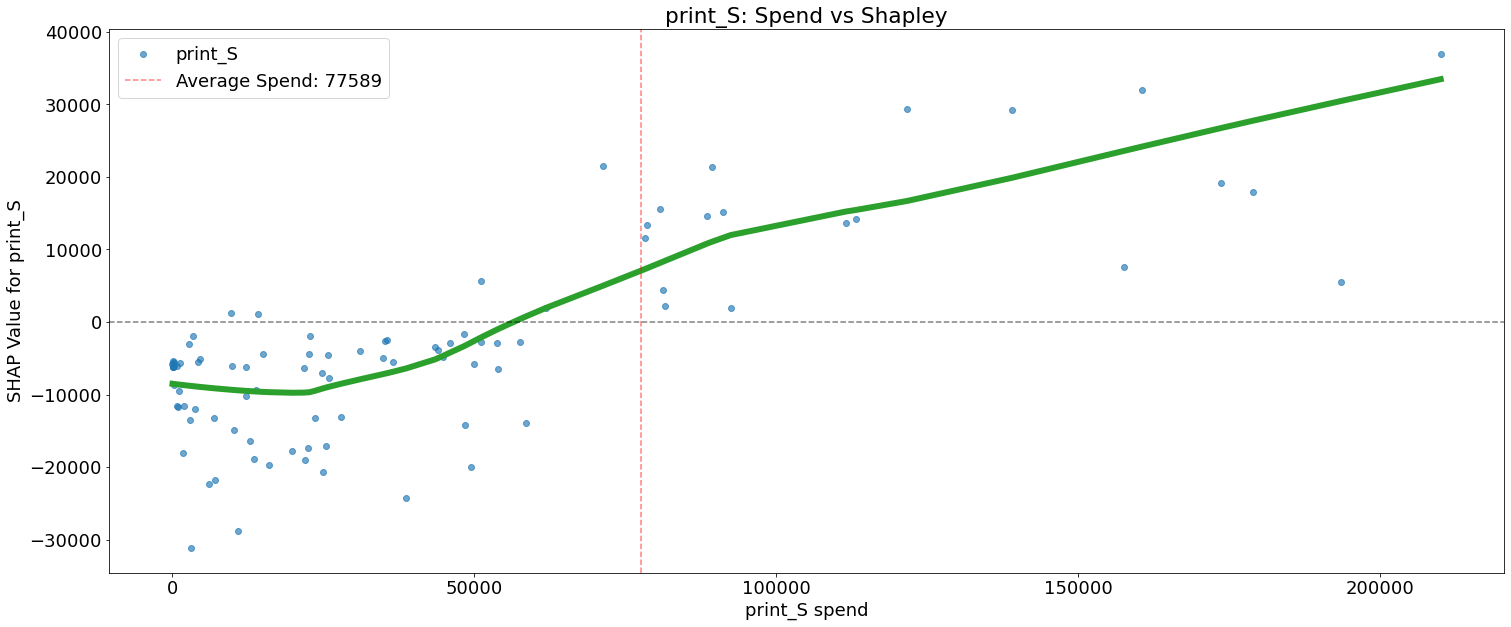

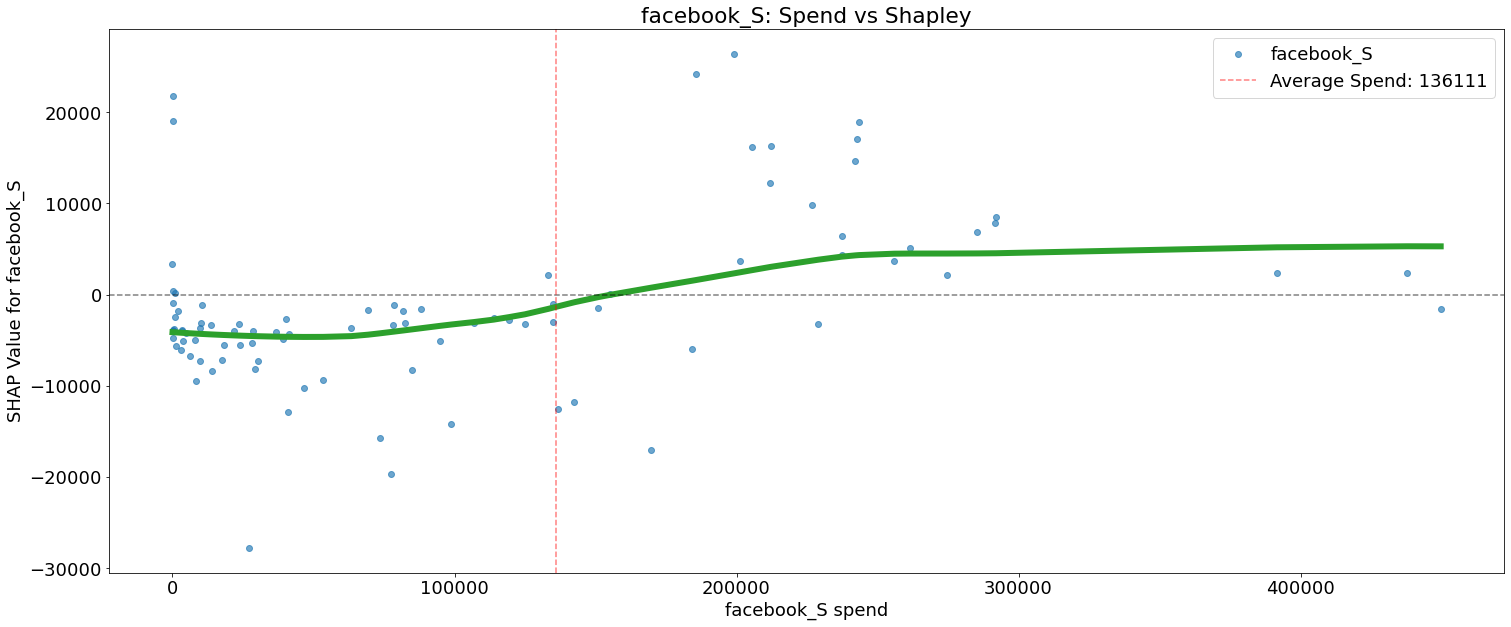

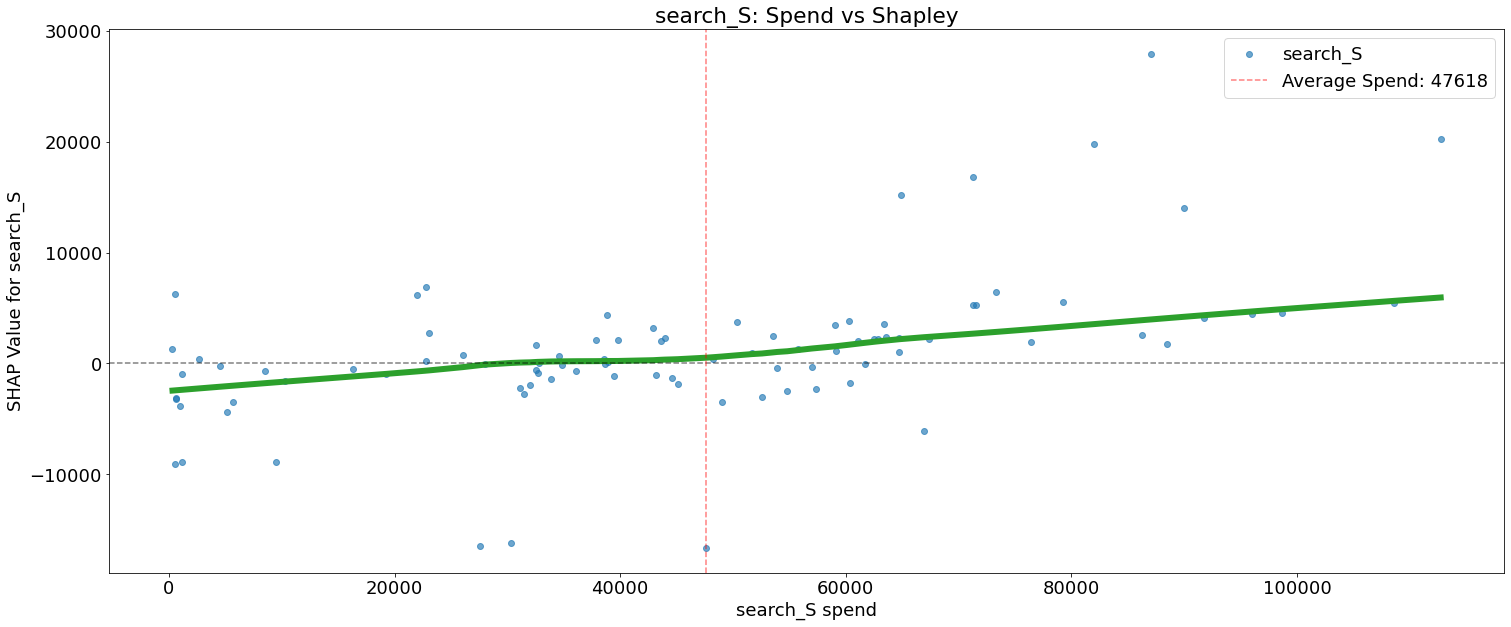

In [37]:
plot_shap_vs_spend(result["df_shap_values"], result["x_input_interval_nontransformed"], result["x_input_interval_transformed"], features, media_channels)

## Multiobjective

In [38]:
tscv = TimeSeriesSplit(n_splits=3, test_size = 10)

OPTUNA_MULTIOBJECTIVE_TRIALS = 1000

adstock_features_params = {}
adstock_features_params["tv_S_adstock"] = (0.3, 0.8)
adstock_features_params["ooh_S_adstock"] = (0.1, 0.4)
adstock_features_params["print_S_adstock"] = (0.1, 0.4)
adstock_features_params["facebook_S_adstock"] = (0.0, 0.4)
adstock_features_params["search_S_adstock"] = (0.0, 0.3)
adstock_features_params["newsletter_adstock"] = (0.1, 0.4)

experiment_multi = optuna_optimize(trials = OPTUNA_MULTIOBJECTIVE_TRIALS, 
                                   data = data, 
                                   target = target, 
                                   features = features, 
                                   adstock_features=media_channels + organic_channels, 
                                   adstock_features_params = adstock_features_params, 
                                   media_features=media_channels, 
                                   tscv = tscv, 
                                   is_multiobjective=True)

data size: 208
media features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']
adstock features: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
features: ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S', 'newsletter']
is_multiobjective: True


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/1000 [00:00<?, ?it/s]

[W 2022-06-08 18:35:16,580] Trial 11 failed, because the objective function returned nan.
[W 2022-06-08 18:35:17,148] Trial 13 failed, because the objective function returned nan.
[W 2022-06-08 18:35:18,575] Trial 17 failed, because the objective function returned nan.
[W 2022-06-08 18:35:19,088] Trial 18 failed, because the objective function returned nan.
[W 2022-06-08 18:35:24,603] Trial 31 failed, because the objective function returned nan.
[W 2022-06-08 18:35:24,724] Trial 32 failed, because the objective function returned nan.
[W 2022-06-08 18:35:26,701] Trial 37 failed, because the objective function returned nan.
[W 2022-06-08 18:35:28,337] Trial 41 failed, because the objective function returned nan.
[W 2022-06-08 18:35:32,809] Trial 54 failed, because the objective function returned nan.
[W 2022-06-08 18:38:29,021] Trial 536 failed, because the objective function returned nan.


In [39]:
fig = opt.visualization.plot_pareto_front(experiment_multi, target_names = ["RMSE", "RSSD"])
fig.show()

plot_pareto_front is experimental (supported from v2.4.0). The interface can change in the future.


In [40]:
#how many best models
len(experiment_multi.best_trials)

30

## Iterate through best models and rebuild 

applying geometric adstock transformation on tv_S with alpha 0.49827139116063507
applying geometric adstock transformation on ooh_S with alpha 0.3547586954695958
applying geometric adstock transformation on print_S with alpha 0.256092310271138
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.12268588332428096
applying geometric adstock transformation on newsletter with alpha 0.36373549226864943
predicting 92
RMSE: 137013.04824965907
MAPE: 0.03691824448274075
NRMSE: 0.0444667334234098
R2: 0.9666662940364682

DECOMP.RSSD: 0.24706568630667414


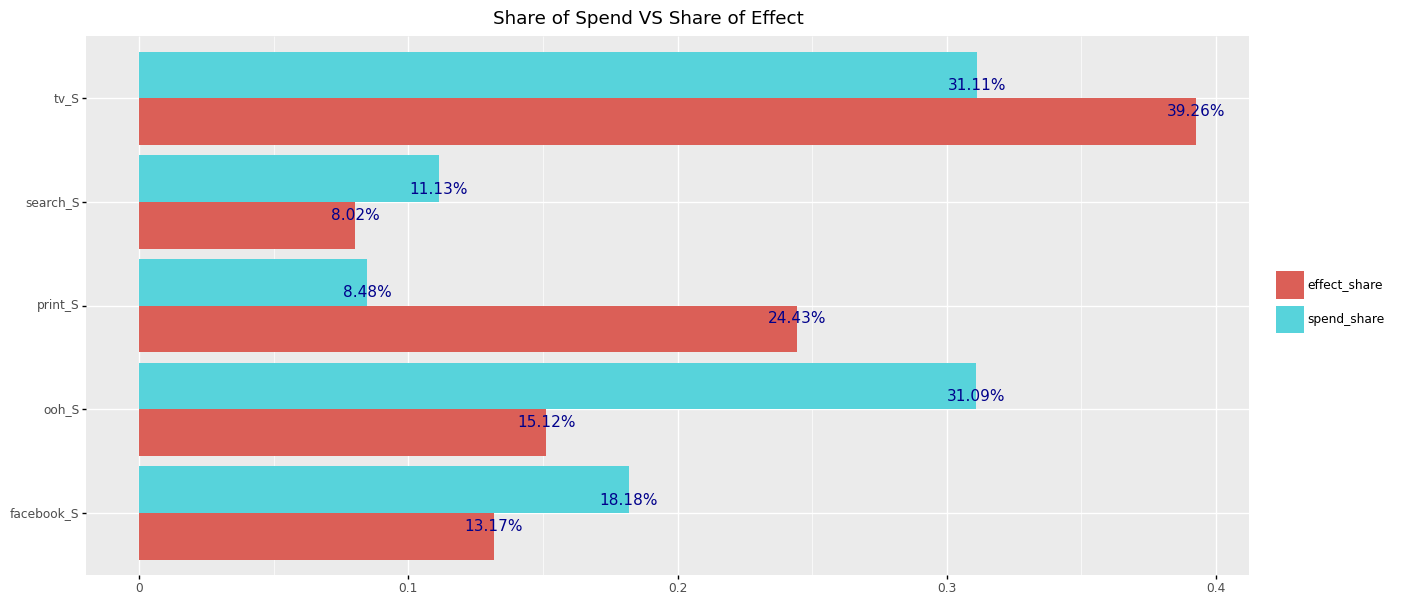


applying geometric adstock transformation on tv_S with alpha 0.510712275296249
applying geometric adstock transformation on ooh_S with alpha 0.3887945244033776
applying geometric adstock transformation on print_S with alpha 0.22563115746762197
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.12268588332428096
applying geometric adstock transformation on newsletter with alpha 0.15597010721539173
predicting 92
RMSE: 255976.76766240815
MAPE: 0.07859151162715497
NRMSE: 0.08307566932960878
R2: 0.8836514850216068

DECOMP.RSSD: 0.24288169067695298


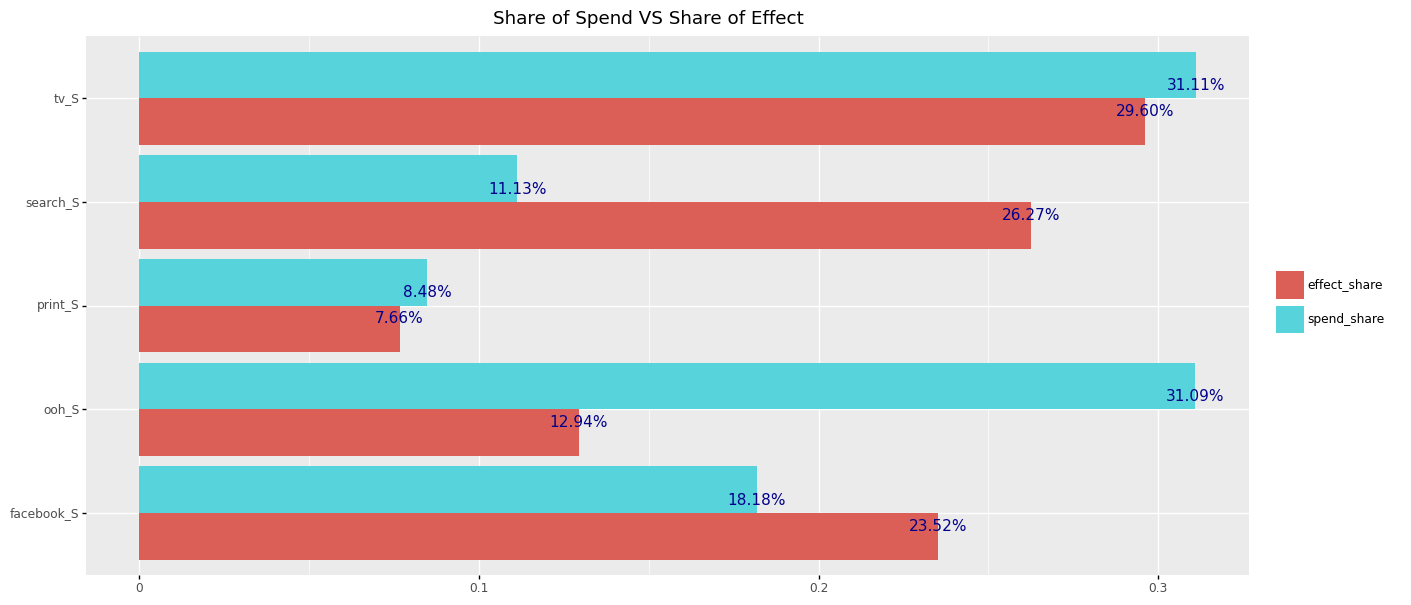


applying geometric adstock transformation on tv_S with alpha 0.48713539787806015
applying geometric adstock transformation on ooh_S with alpha 0.3547586954695958
applying geometric adstock transformation on print_S with alpha 0.3682297611037404
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.19558837785078015
applying geometric adstock transformation on newsletter with alpha 0.1689863817673259
predicting 92
RMSE: 82048.81790725222
MAPE: 0.027893186920425306
NRMSE: 0.026628434008267934
R2: 0.9880462436357813

DECOMP.RSSD: 0.4317975058062308


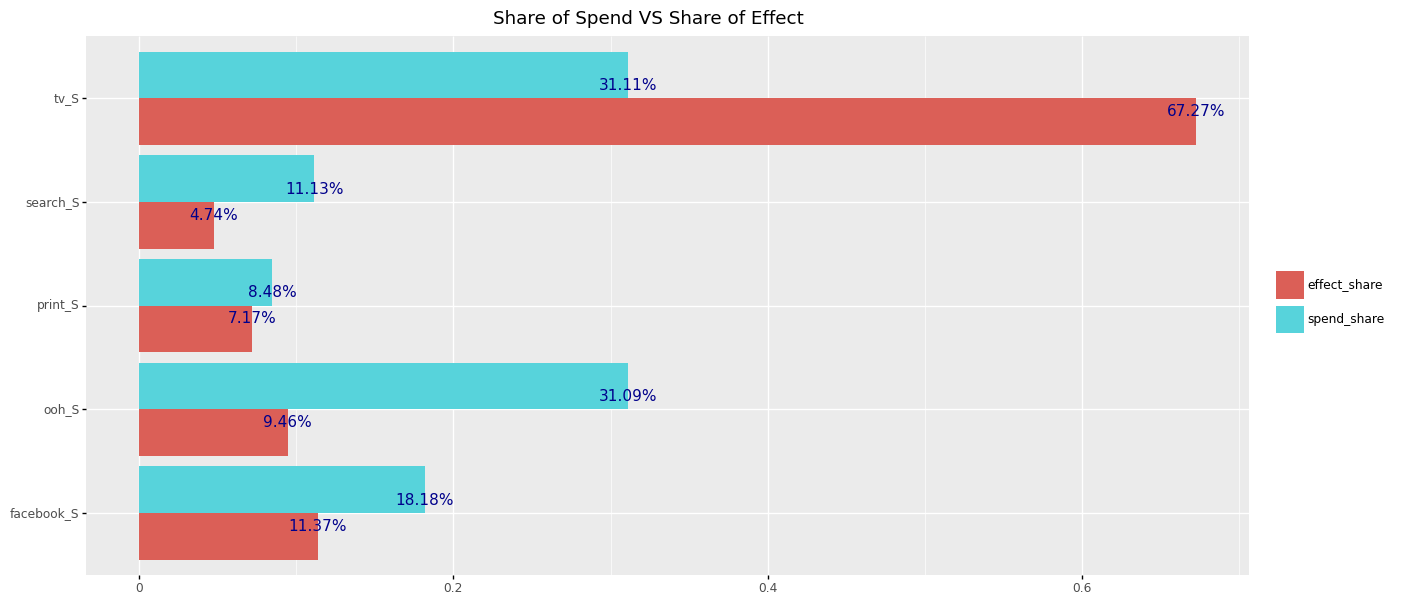


applying geometric adstock transformation on tv_S with alpha 0.53279900906623
applying geometric adstock transformation on ooh_S with alpha 0.3887945244033776
applying geometric adstock transformation on print_S with alpha 0.3507940361536618
applying geometric adstock transformation on facebook_S with alpha 0.25048812865256614
applying geometric adstock transformation on search_S with alpha 0.11033493981577597
applying geometric adstock transformation on newsletter with alpha 0.1692009435153276
predicting 92
RMSE: 238306.72213984
MAPE: 0.07496521273266502
NRMSE: 0.07734096585523725
R2: 0.8991601179090256

DECOMP.RSSD: 0.2779321283391911


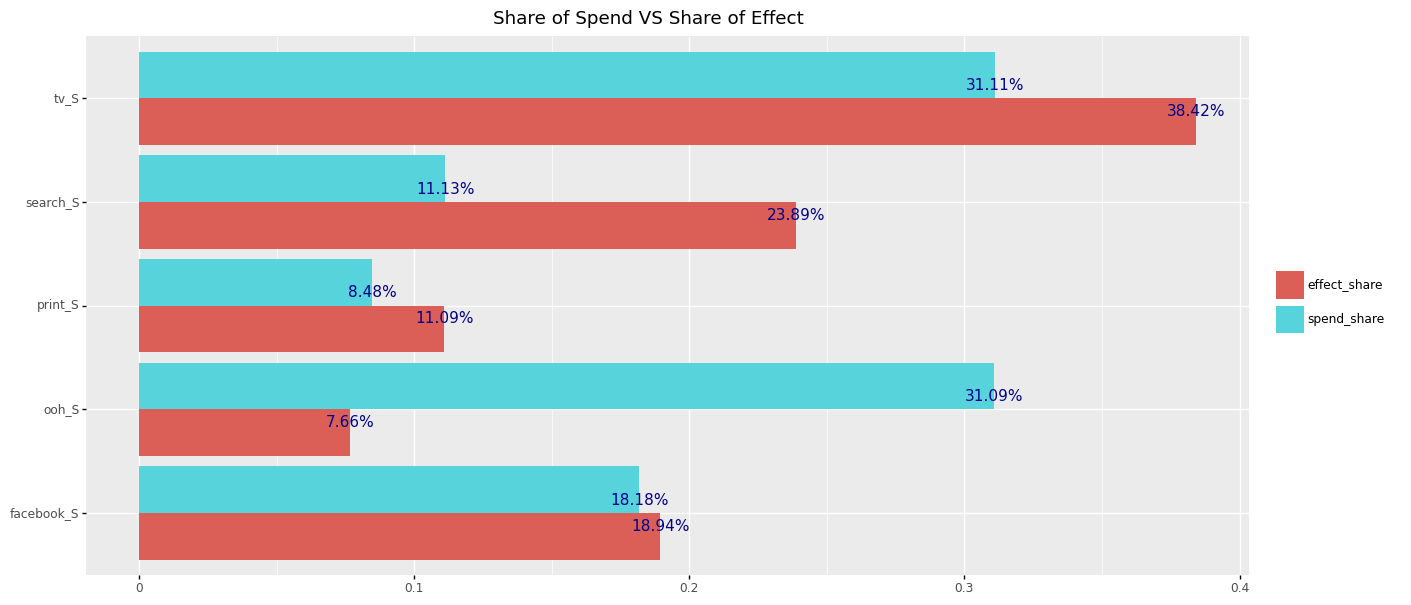


applying geometric adstock transformation on tv_S with alpha 0.47460478730633043
applying geometric adstock transformation on ooh_S with alpha 0.2866260100683621
applying geometric adstock transformation on print_S with alpha 0.3507940361536618
applying geometric adstock transformation on facebook_S with alpha 0.35483456970604693
applying geometric adstock transformation on search_S with alpha 0.01960690223968271
applying geometric adstock transformation on newsletter with alpha 0.2703835691657889
predicting 92
RMSE: 209402.46137651269
MAPE: 0.06234573991625752
NRMSE: 0.06796026763281961
R2: 0.9221384029517744

DECOMP.RSSD: 0.24181399168508733


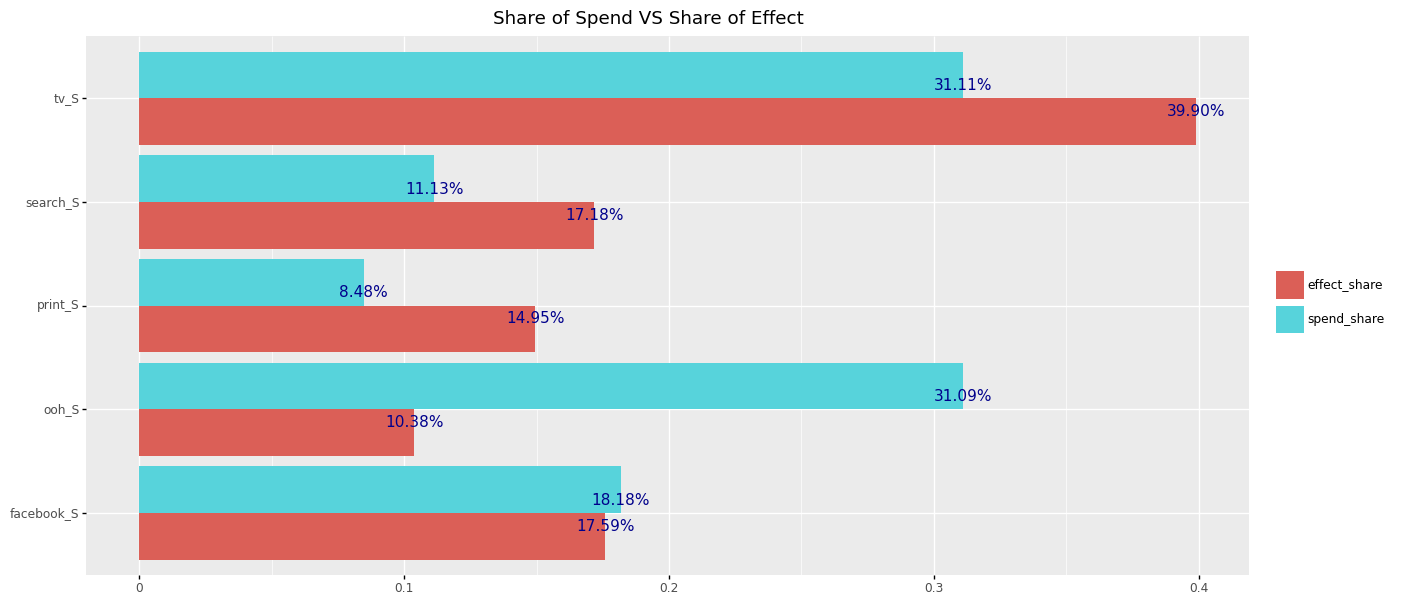


applying geometric adstock transformation on tv_S with alpha 0.510712275296249
applying geometric adstock transformation on ooh_S with alpha 0.3887945244033776
applying geometric adstock transformation on print_S with alpha 0.317577298124541
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.04412204427871138
applying geometric adstock transformation on newsletter with alpha 0.3209332706874169
predicting 92
RMSE: 256043.55094435436
MAPE: 0.0792933304154648
NRMSE: 0.08309734342877947
R2: 0.8835907674076691

DECOMP.RSSD: 0.24619716500501024


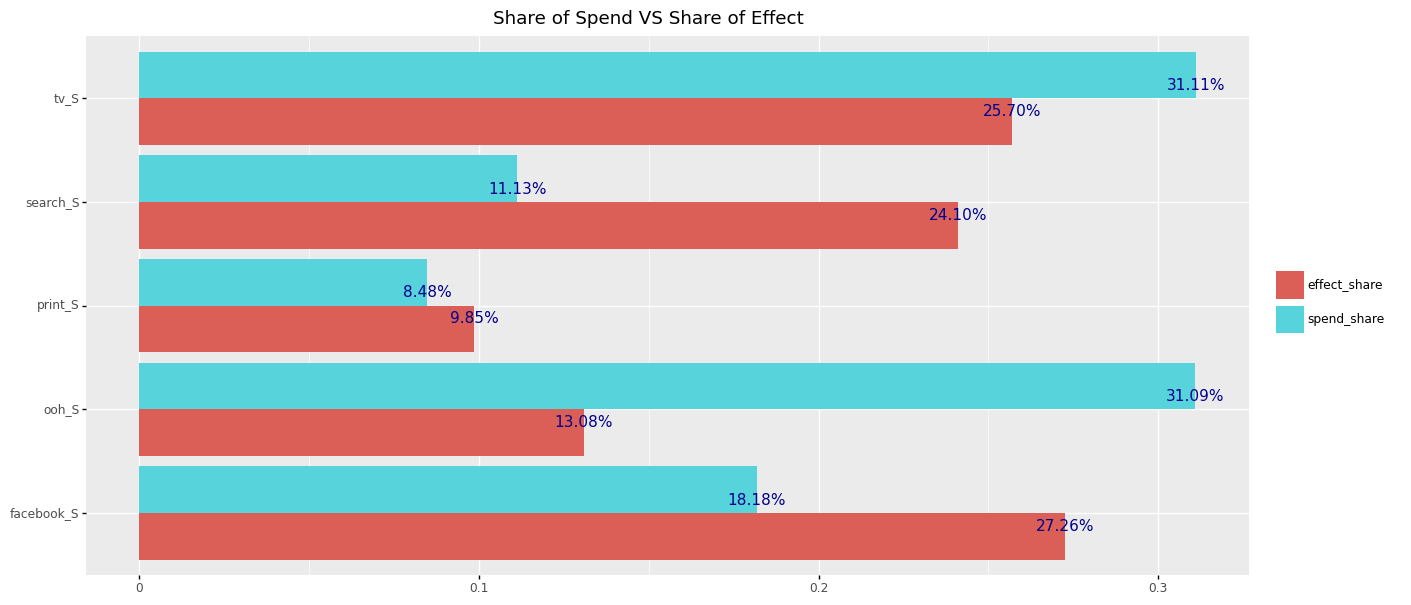


applying geometric adstock transformation on tv_S with alpha 0.4728479967519597
applying geometric adstock transformation on ooh_S with alpha 0.3547586954695958
applying geometric adstock transformation on print_S with alpha 0.3507940361536618
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.12268588332428096
applying geometric adstock transformation on newsletter with alpha 0.19540104249155918
predicting 92
RMSE: 229836.65517968914
MAPE: 0.069264943657857
NRMSE: 0.07459205825550873
R2: 0.9062009740462215

DECOMP.RSSD: 0.20747980381902045


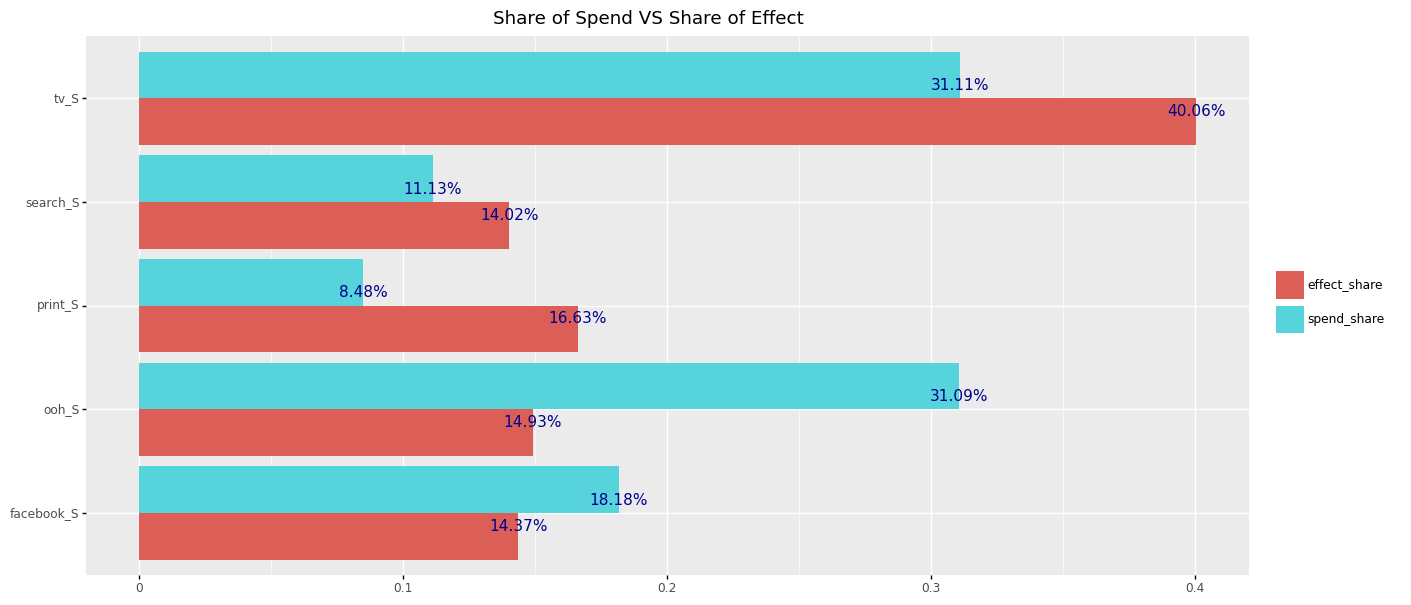


applying geometric adstock transformation on tv_S with alpha 0.5598869742780088
applying geometric adstock transformation on ooh_S with alpha 0.2577070546908058
applying geometric adstock transformation on print_S with alpha 0.3507940361536618
applying geometric adstock transformation on facebook_S with alpha 0.37473189572990323
applying geometric adstock transformation on search_S with alpha 0.23396266375728714
applying geometric adstock transformation on newsletter with alpha 0.15597010721539173
predicting 92
RMSE: 204627.30219121146
MAPE: 0.05700499117655451
NRMSE: 0.06641051939161395
R2: 0.9256489852572397

DECOMP.RSSD: 0.25835711492325003


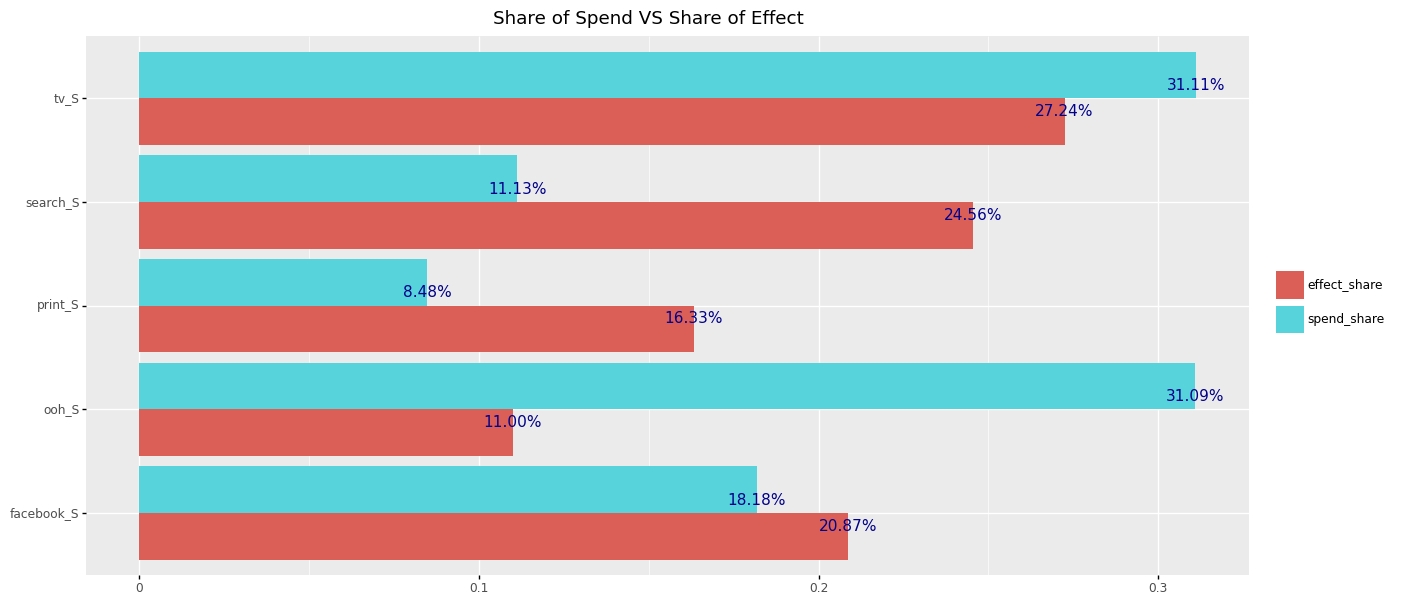


applying geometric adstock transformation on tv_S with alpha 0.510712275296249
applying geometric adstock transformation on ooh_S with alpha 0.3887945244033776
applying geometric adstock transformation on print_S with alpha 0.317577298124541
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.04412204427871138
applying geometric adstock transformation on newsletter with alpha 0.24238926272494418
predicting 92
RMSE: 255752.2353283932
MAPE: 0.07841996352497134
NRMSE: 0.08300279875582674
R2: 0.8838555078039309

DECOMP.RSSD: 0.23621344284371013


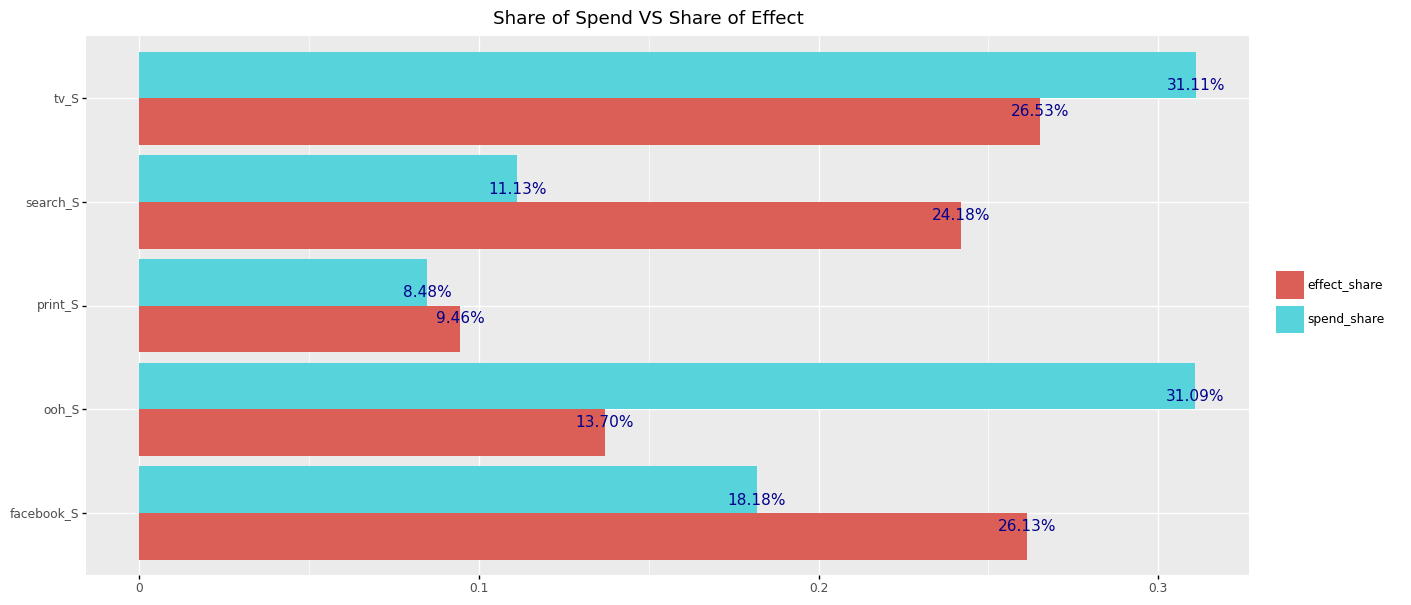


applying geometric adstock transformation on tv_S with alpha 0.4728479967519597
applying geometric adstock transformation on ooh_S with alpha 0.2577070546908058
applying geometric adstock transformation on print_S with alpha 0.38889760115769845
applying geometric adstock transformation on facebook_S with alpha 0.37473189572990323
applying geometric adstock transformation on search_S with alpha 0.11033493981577597
applying geometric adstock transformation on newsletter with alpha 0.15597010721539173
predicting 92
RMSE: 203881.8094417648
MAPE: 0.05764900377694846
NRMSE: 0.06616857435220189
R2: 0.9261897456997081

DECOMP.RSSD: 0.23649612569340403


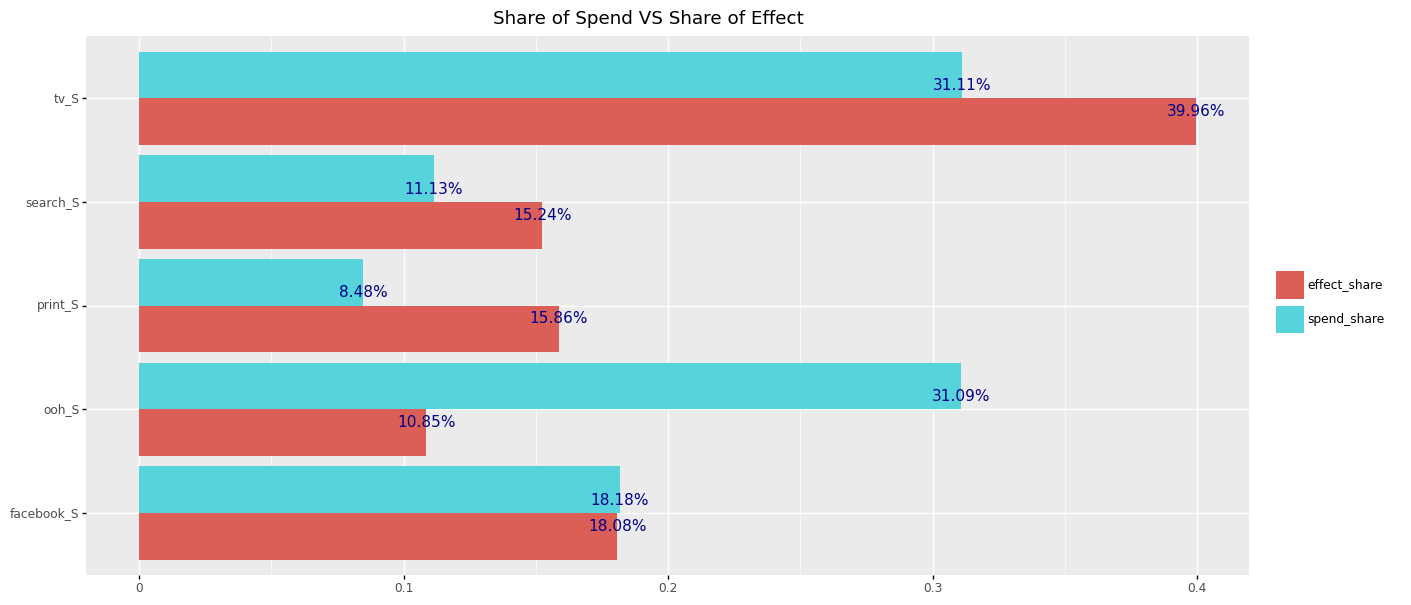


applying geometric adstock transformation on tv_S with alpha 0.5475732635069872
applying geometric adstock transformation on ooh_S with alpha 0.2577070546908058
applying geometric adstock transformation on print_S with alpha 0.317715852516508
applying geometric adstock transformation on facebook_S with alpha 0.26937297332996696
applying geometric adstock transformation on search_S with alpha 0.23396266375728714
applying geometric adstock transformation on newsletter with alpha 0.2025452055093628
predicting 92
RMSE: 209761.2680396658
MAPE: 0.06120273530345058
NRMSE: 0.06807671610575557
R2: 0.9218713459688617

DECOMP.RSSD: 0.21217489417423852


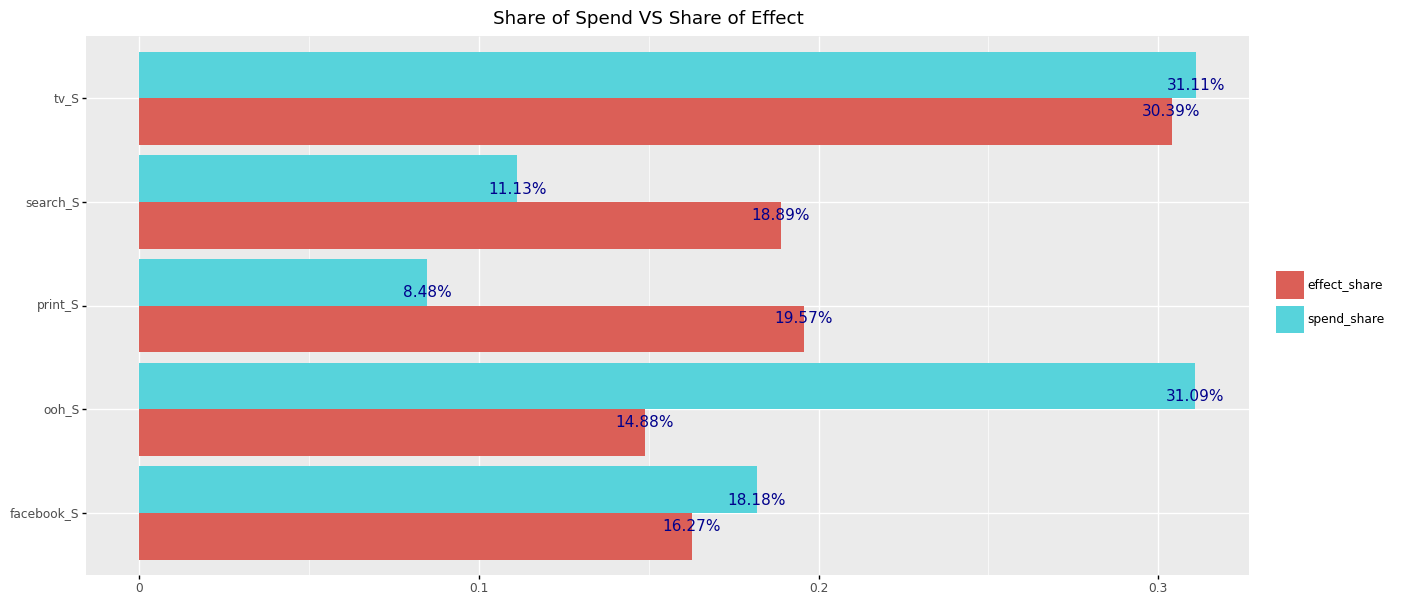


applying geometric adstock transformation on tv_S with alpha 0.48713539787806015
applying geometric adstock transformation on ooh_S with alpha 0.3284858845986153
applying geometric adstock transformation on print_S with alpha 0.256092310271138
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.009150074981714829
applying geometric adstock transformation on newsletter with alpha 0.16728079283816794
predicting 92
RMSE: 82048.81790725239
MAPE: 0.027893186920425327
NRMSE: 0.02662843400826799
R2: 0.9880462436357812

DECOMP.RSSD: 0.4263340369636464


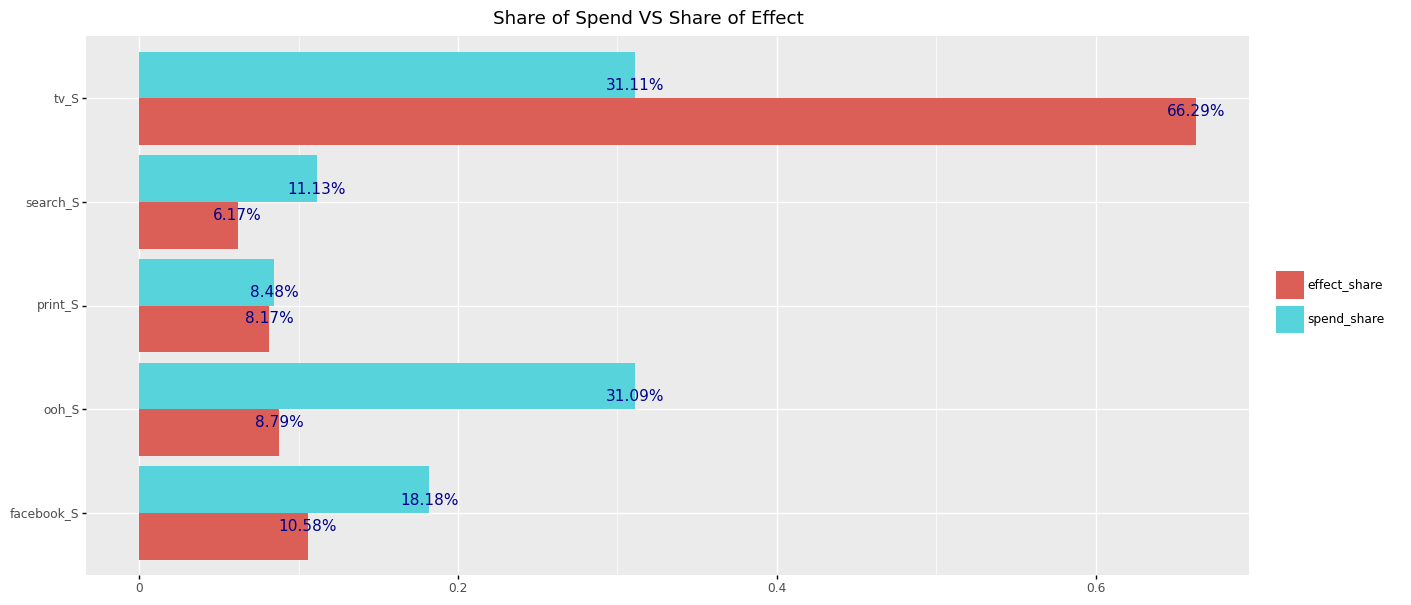


applying geometric adstock transformation on tv_S with alpha 0.53279900906623
applying geometric adstock transformation on ooh_S with alpha 0.3547586954695958
applying geometric adstock transformation on print_S with alpha 0.3507940361536618
applying geometric adstock transformation on facebook_S with alpha 0.25048812865256614
applying geometric adstock transformation on search_S with alpha 0.12268588332428096
applying geometric adstock transformation on newsletter with alpha 0.1692009435153276
predicting 92
RMSE: 238733.59077981208
MAPE: 0.07038674356665535
NRMSE: 0.07747950341981917
R2: 0.8987985340173636

DECOMP.RSSD: 0.29479056268147924


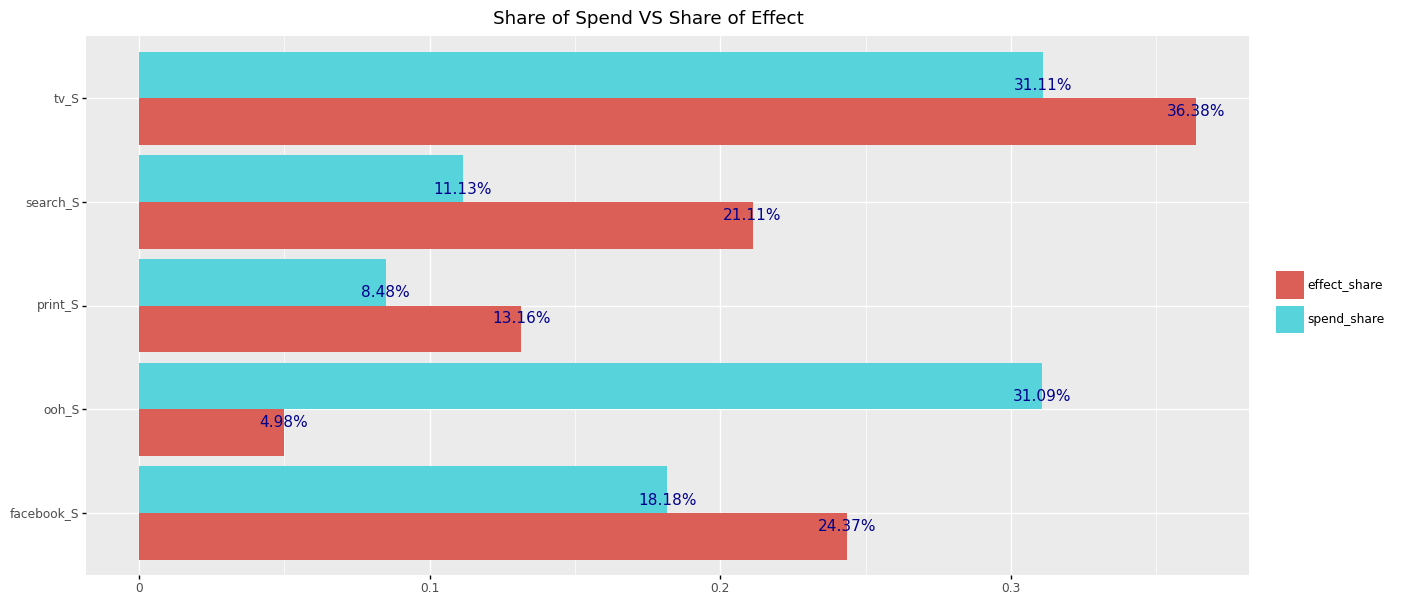


applying geometric adstock transformation on tv_S with alpha 0.53279900906623
applying geometric adstock transformation on ooh_S with alpha 0.3887945244033776
applying geometric adstock transformation on print_S with alpha 0.38889760115769845
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.12268588332428096
applying geometric adstock transformation on newsletter with alpha 0.15597010721539173
predicting 92
RMSE: 237284.81340032193
MAPE: 0.07000649224648994
NRMSE: 0.07700931172387013
R2: 0.9000231083255739

DECOMP.RSSD: 0.2745683679726741


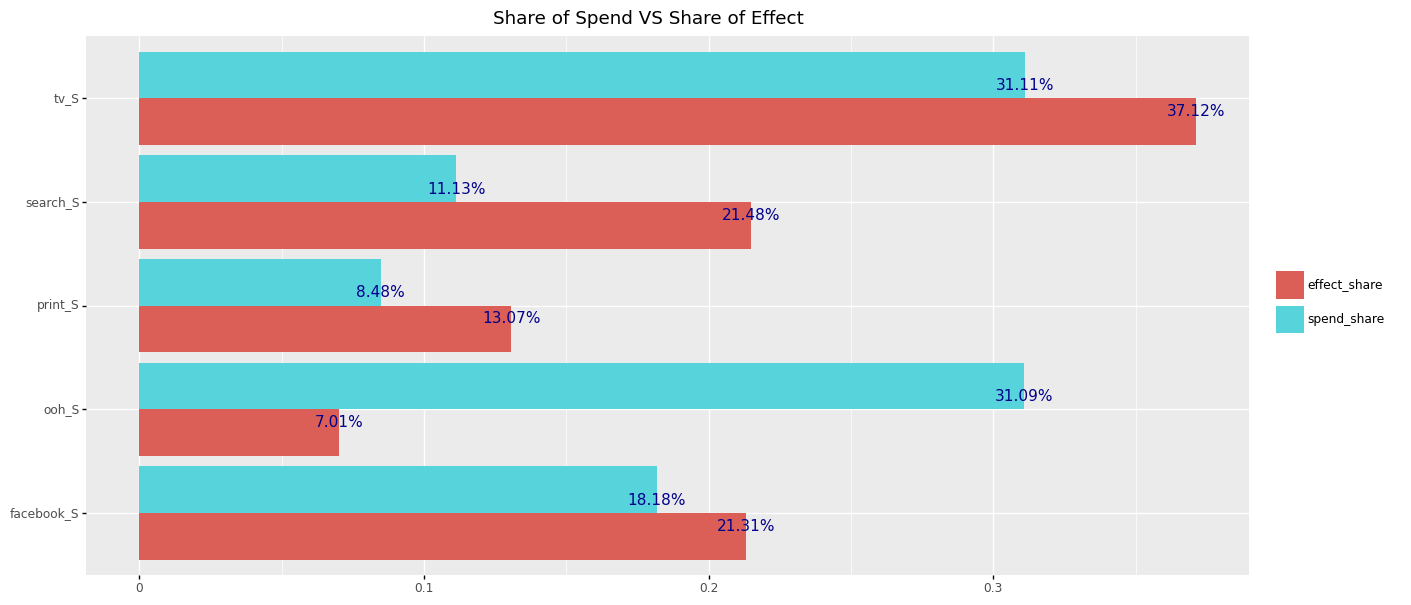


applying geometric adstock transformation on tv_S with alpha 0.510712275296249
applying geometric adstock transformation on ooh_S with alpha 0.3887945244033776
applying geometric adstock transformation on print_S with alpha 0.22563115746762197
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.07703297031615237
applying geometric adstock transformation on newsletter with alpha 0.24238926272494418
predicting 92
RMSE: 255642.9445283408
MAPE: 0.0782515977836697
NRMSE: 0.08296732910579234
R2: 0.883954750825527

DECOMP.RSSD: 0.23931578539224146


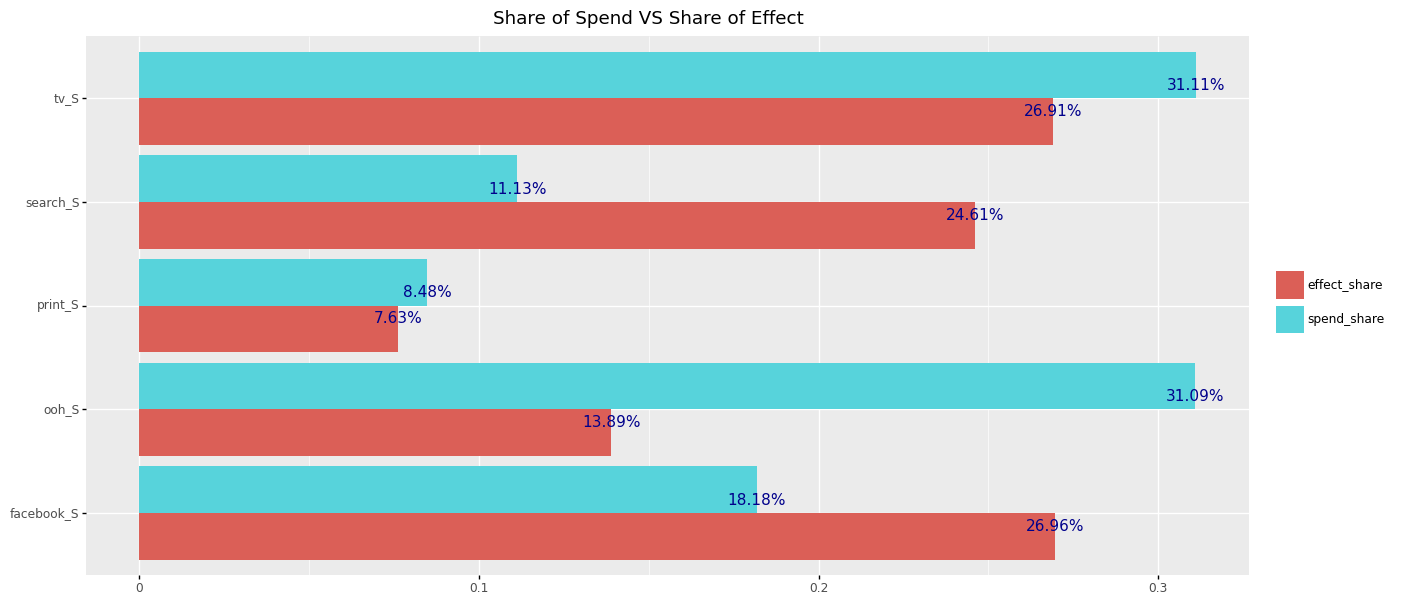


applying geometric adstock transformation on tv_S with alpha 0.5475732635069872
applying geometric adstock transformation on ooh_S with alpha 0.1544315043086881
applying geometric adstock transformation on print_S with alpha 0.256092310271138
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.09310858767707213
applying geometric adstock transformation on newsletter with alpha 0.2010687375313321
predicting 92
RMSE: 140724.68212977983
MAPE: 0.0393710337877376
NRMSE: 0.04567132113546399
R2: 0.9648358360904007

DECOMP.RSSD: 0.1429612668302153


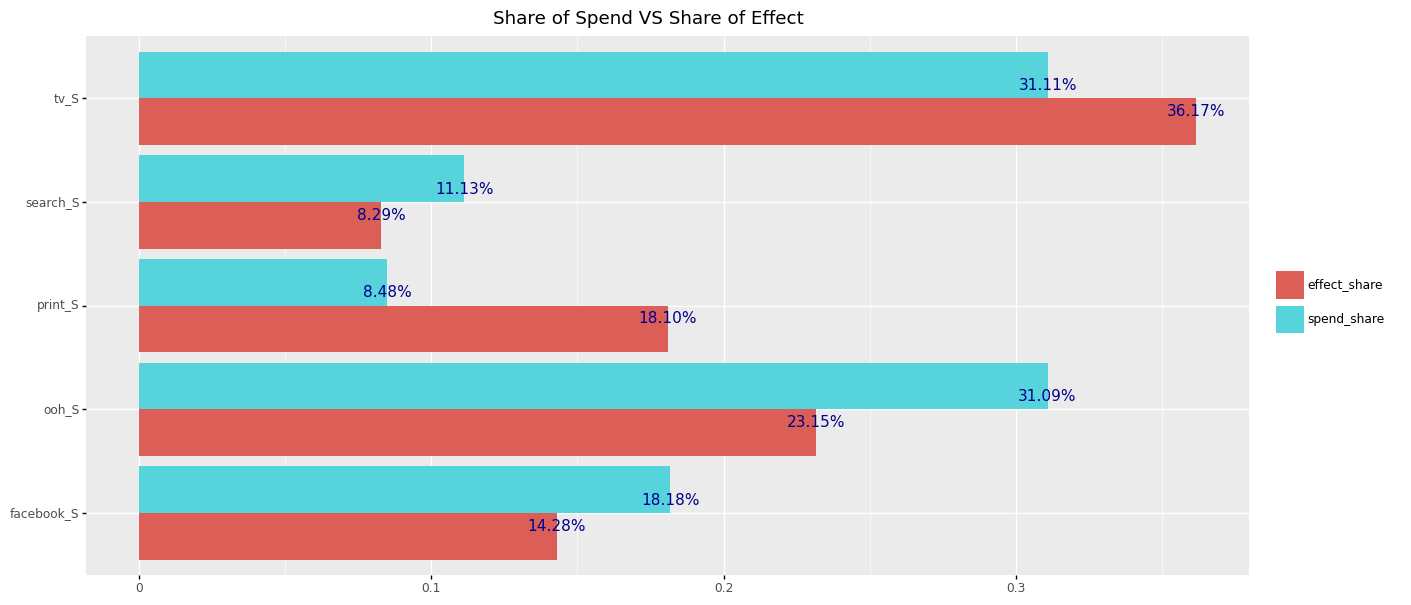


applying geometric adstock transformation on tv_S with alpha 0.53279900906623
applying geometric adstock transformation on ooh_S with alpha 0.3547586954695958
applying geometric adstock transformation on print_S with alpha 0.256092310271138
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.12268588332428096
applying geometric adstock transformation on newsletter with alpha 0.19540104249155918
predicting 92
RMSE: 142476.4054471161
MAPE: 0.03874963537788888
NRMSE: 0.04623983205306381
R2: 0.9639549491511246

DECOMP.RSSD: 0.23404830825926767


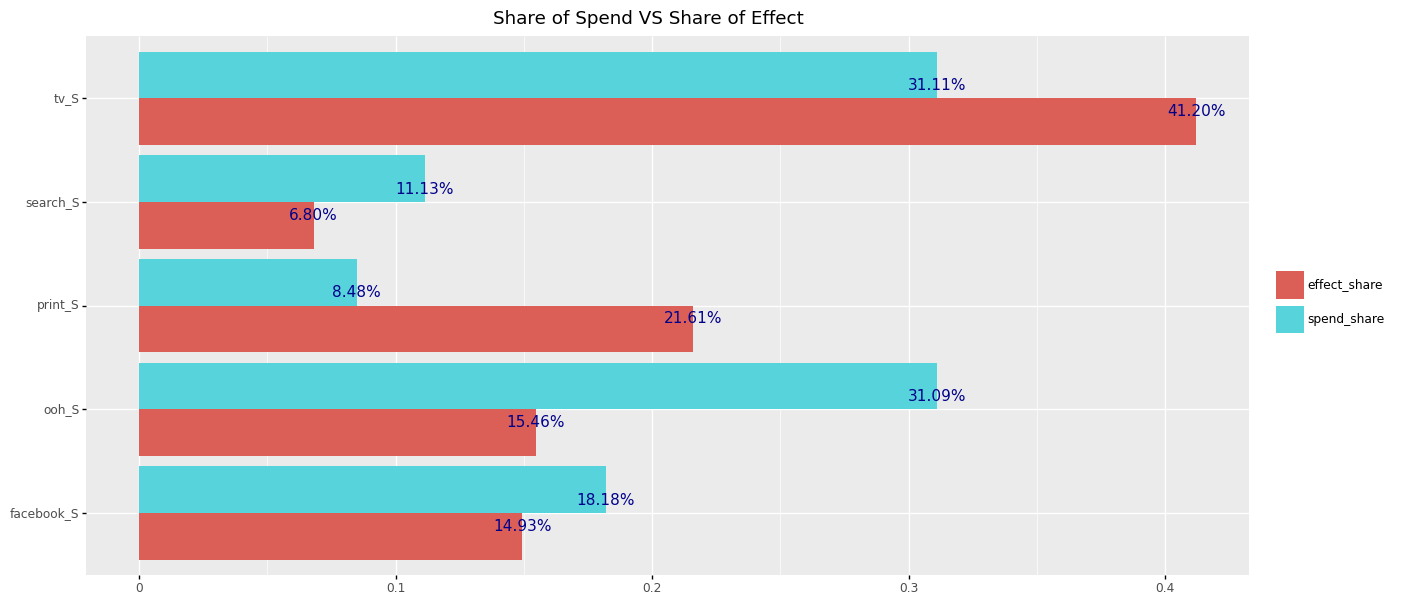


applying geometric adstock transformation on tv_S with alpha 0.48713539787806015
applying geometric adstock transformation on ooh_S with alpha 0.3284858845986153
applying geometric adstock transformation on print_S with alpha 0.3507940361536618
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.07106116769234462
applying geometric adstock transformation on newsletter with alpha 0.2703835691657889
predicting 92
RMSE: 234906.71672545216
MAPE: 0.07101204079983103
NRMSE: 0.07623751522530713
R2: 0.9020170270027044

DECOMP.RSSD: 0.28244571062698043


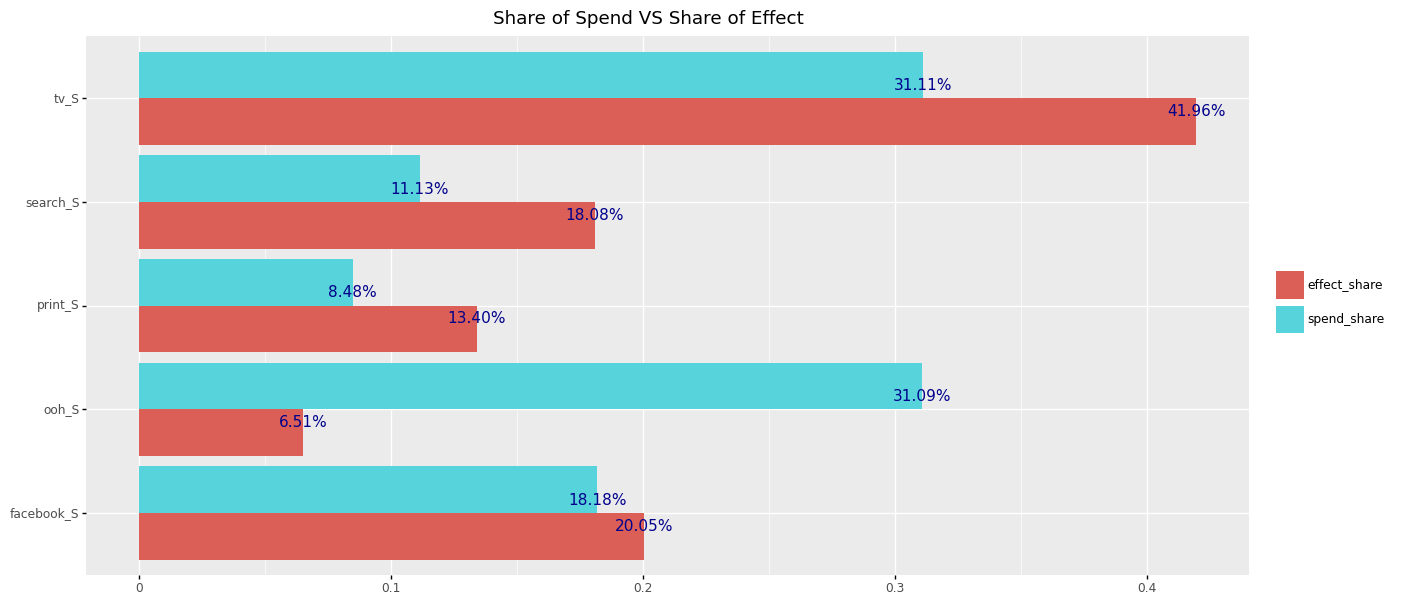


applying geometric adstock transformation on tv_S with alpha 0.48713539787806015
applying geometric adstock transformation on ooh_S with alpha 0.2577070546908058
applying geometric adstock transformation on print_S with alpha 0.2441520841773487
applying geometric adstock transformation on facebook_S with alpha 0.37473189572990323
applying geometric adstock transformation on search_S with alpha 0.11033493981577597
applying geometric adstock transformation on newsletter with alpha 0.16728079283816794
predicting 92
RMSE: 204290.90307134346
MAPE: 0.05775200924365995
NRMSE: 0.06630134314761284
R2: 0.9258932445188716

DECOMP.RSSD: 0.2407505746795208


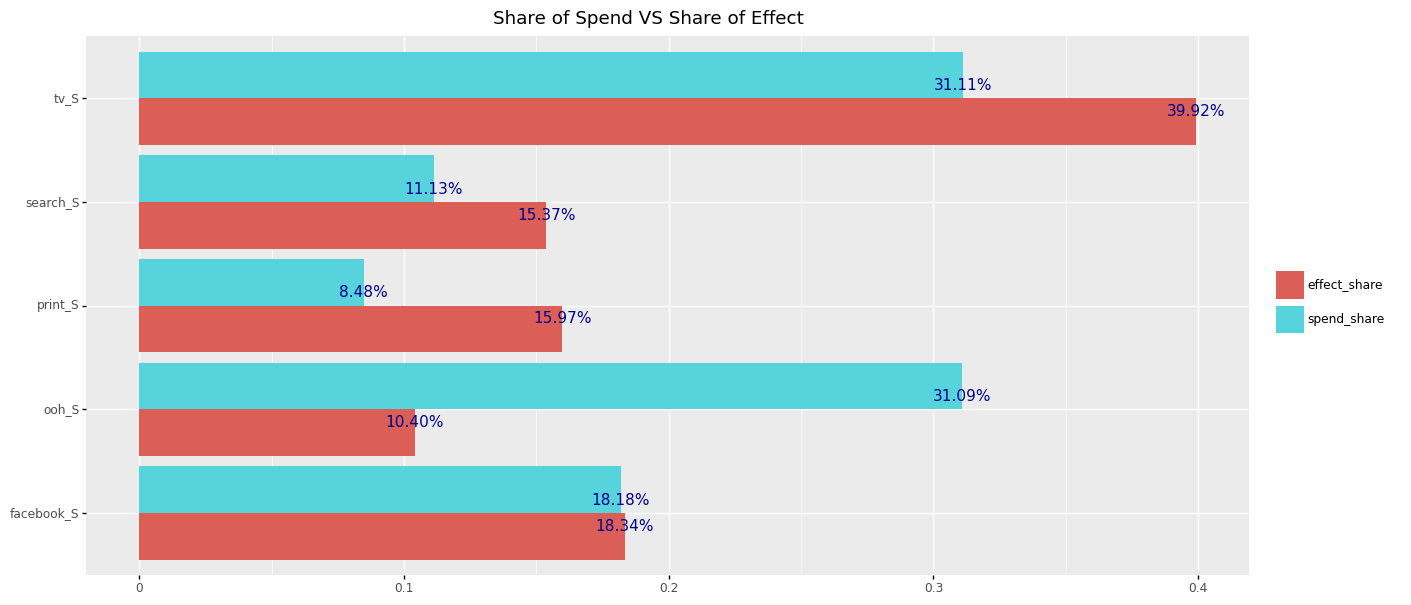


applying geometric adstock transformation on tv_S with alpha 0.5598869742780088
applying geometric adstock transformation on ooh_S with alpha 0.2577070546908058
applying geometric adstock transformation on print_S with alpha 0.3507940361536618
applying geometric adstock transformation on facebook_S with alpha 0.37473189572990323
applying geometric adstock transformation on search_S with alpha 0.23396266375728714
applying geometric adstock transformation on newsletter with alpha 0.15597010721539173
predicting 92
RMSE: 204627.30219121146
MAPE: 0.05700499117655451
NRMSE: 0.06641051939161395
R2: 0.9256489852572397

DECOMP.RSSD: 0.25835711492325003


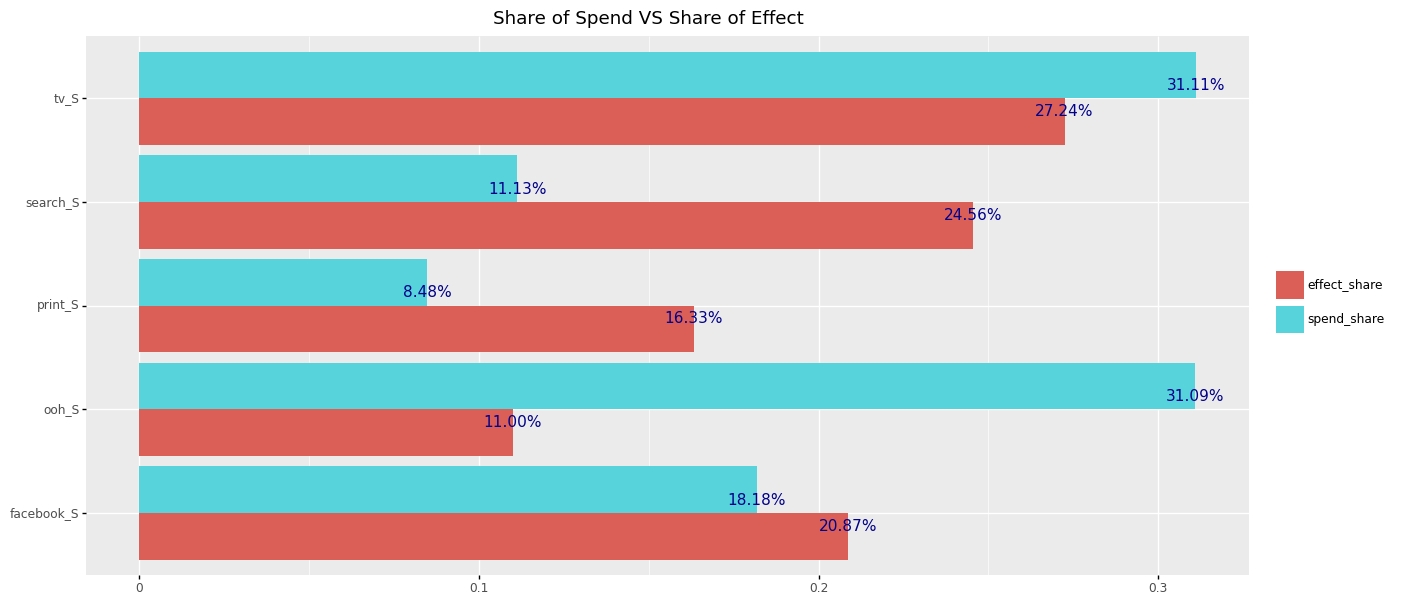


applying geometric adstock transformation on tv_S with alpha 0.49827139116063507
applying geometric adstock transformation on ooh_S with alpha 0.3547586954695958
applying geometric adstock transformation on print_S with alpha 0.256092310271138
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.12268588332428096
applying geometric adstock transformation on newsletter with alpha 0.15597010721539173
predicting 92
RMSE: 140041.68862624106
MAPE: 0.037114764891630785
NRMSE: 0.04544965983794698
R2: 0.9651763394522336

DECOMP.RSSD: 0.24773431206322874


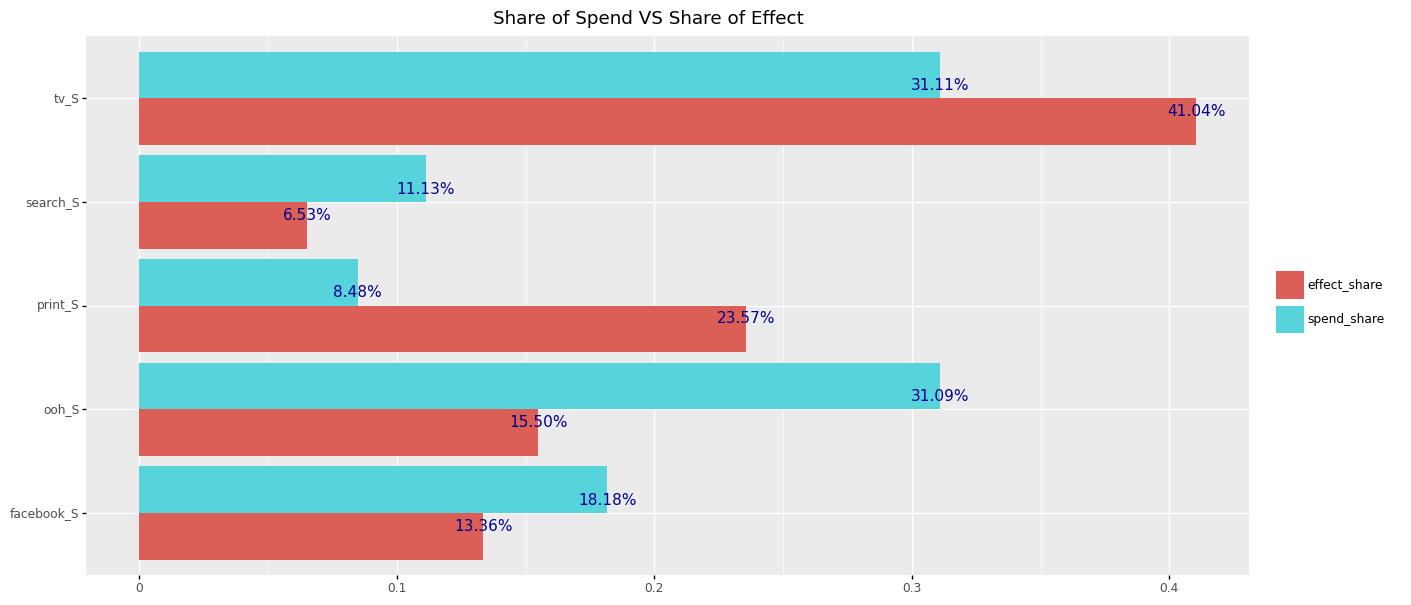


applying geometric adstock transformation on tv_S with alpha 0.4728479967519597
applying geometric adstock transformation on ooh_S with alpha 0.2577070546908058
applying geometric adstock transformation on print_S with alpha 0.38889760115769845
applying geometric adstock transformation on facebook_S with alpha 0.37473189572990323
applying geometric adstock transformation on search_S with alpha 0.11033493981577597
applying geometric adstock transformation on newsletter with alpha 0.15597010721539173
predicting 92
RMSE: 203881.8094417648
MAPE: 0.05764900377694846
NRMSE: 0.06616857435220189
R2: 0.9261897456997081

DECOMP.RSSD: 0.23649612569340403


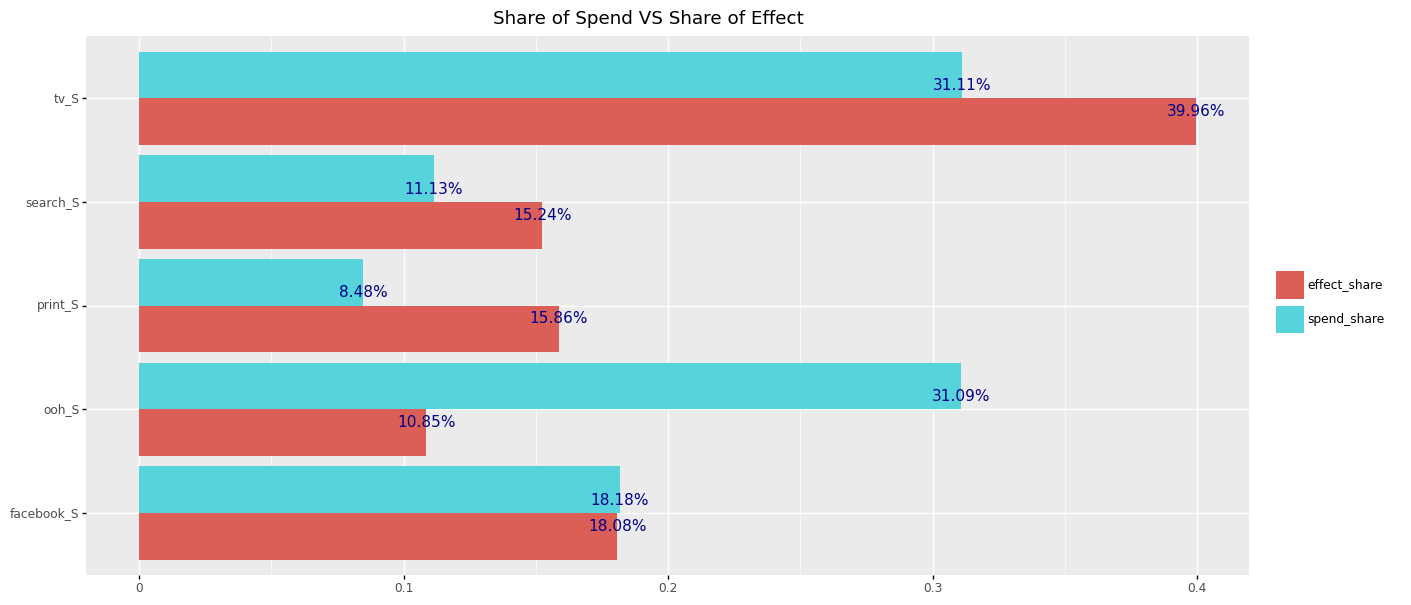


applying geometric adstock transformation on tv_S with alpha 0.5475732635069872
applying geometric adstock transformation on ooh_S with alpha 0.2577070546908058
applying geometric adstock transformation on print_S with alpha 0.3587091126240236
applying geometric adstock transformation on facebook_S with alpha 0.26937297332996696
applying geometric adstock transformation on search_S with alpha 0.23396266375728714
applying geometric adstock transformation on newsletter with alpha 0.15597010721539173
predicting 92
RMSE: 204772.00627690426
MAPE: 0.05977547148763734
NRMSE: 0.06645748220344815
R2: 0.9255437920633736

DECOMP.RSSD: 0.2134407304992052


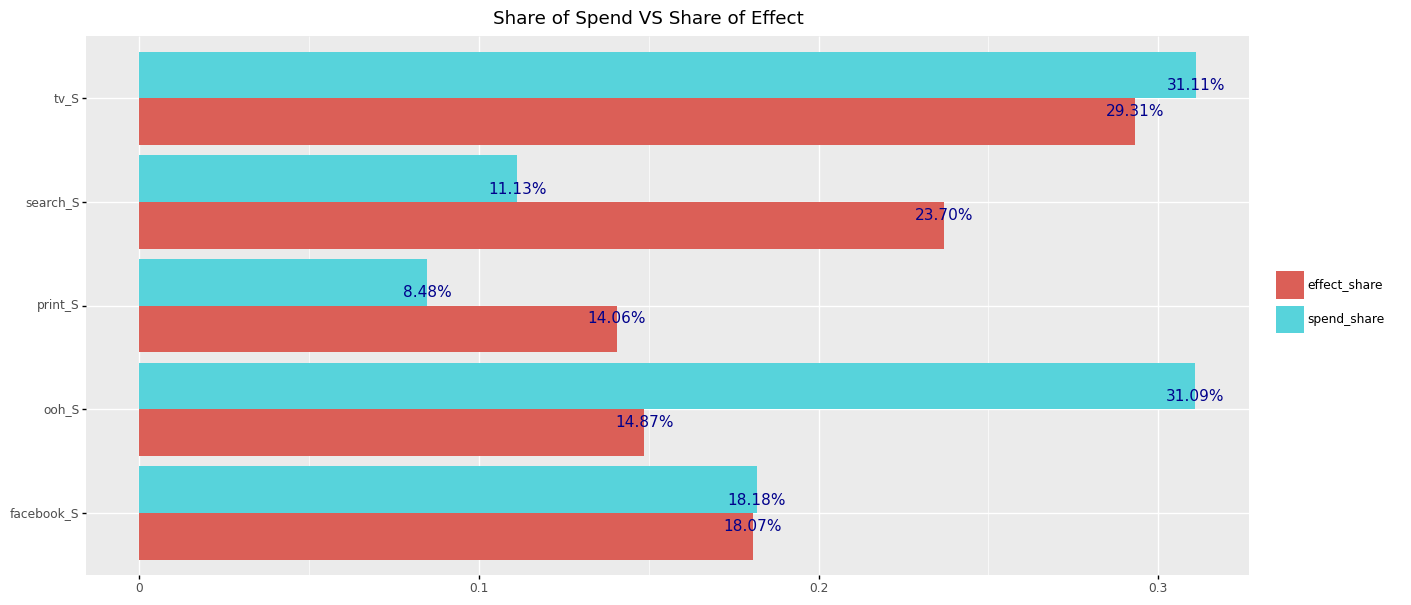


applying geometric adstock transformation on tv_S with alpha 0.7400395437807291
applying geometric adstock transformation on ooh_S with alpha 0.2577070546908058
applying geometric adstock transformation on print_S with alpha 0.317715852516508
applying geometric adstock transformation on facebook_S with alpha 0.26937297332996696
applying geometric adstock transformation on search_S with alpha 0.19526321071415825
applying geometric adstock transformation on newsletter with alpha 0.15597010721539173
predicting 92
RMSE: 210744.64976813766
MAPE: 0.05887353858332345
NRMSE: 0.06839586653509082
R2: 0.9211370790034294

DECOMP.RSSD: 0.2310185045652088


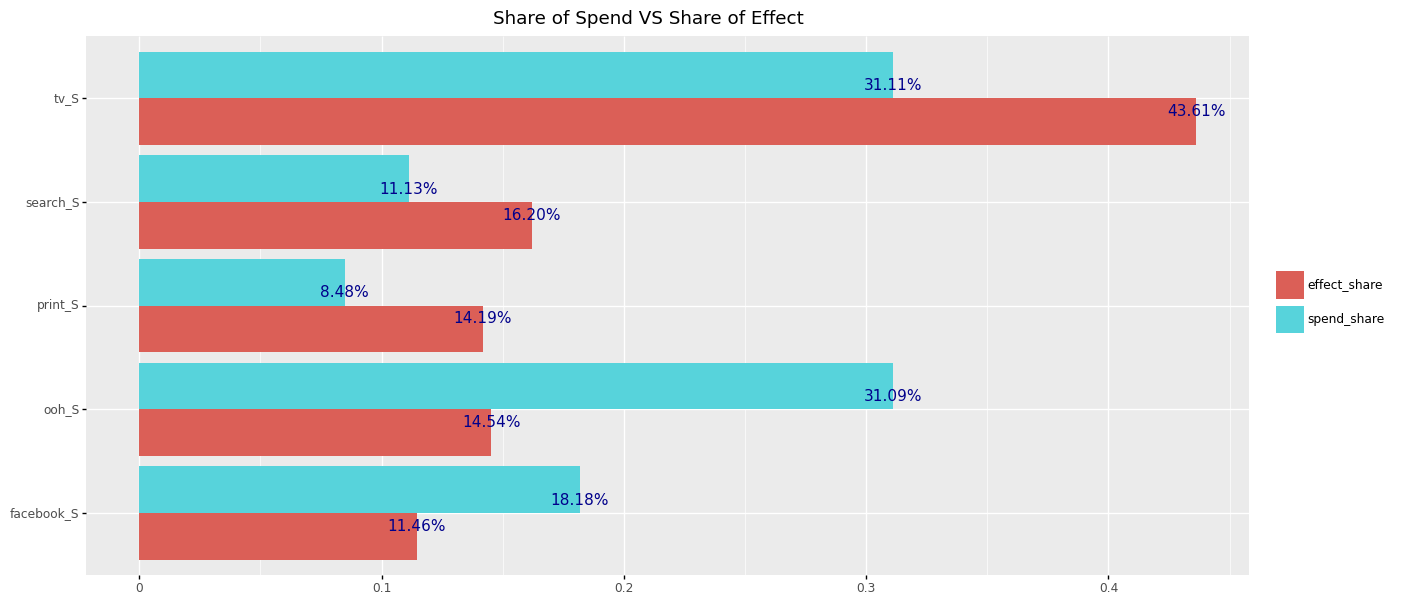


applying geometric adstock transformation on tv_S with alpha 0.48713539787806015
applying geometric adstock transformation on ooh_S with alpha 0.3887945244033776
applying geometric adstock transformation on print_S with alpha 0.3682297611037404
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.12268588332428096
applying geometric adstock transformation on newsletter with alpha 0.1689863817673259
predicting 92
RMSE: 82260.44732943506
MAPE: 0.028060336514759688
NRMSE: 0.026697117022192327
R2: 0.9879844991976703

DECOMP.RSSD: 0.4411454141011011


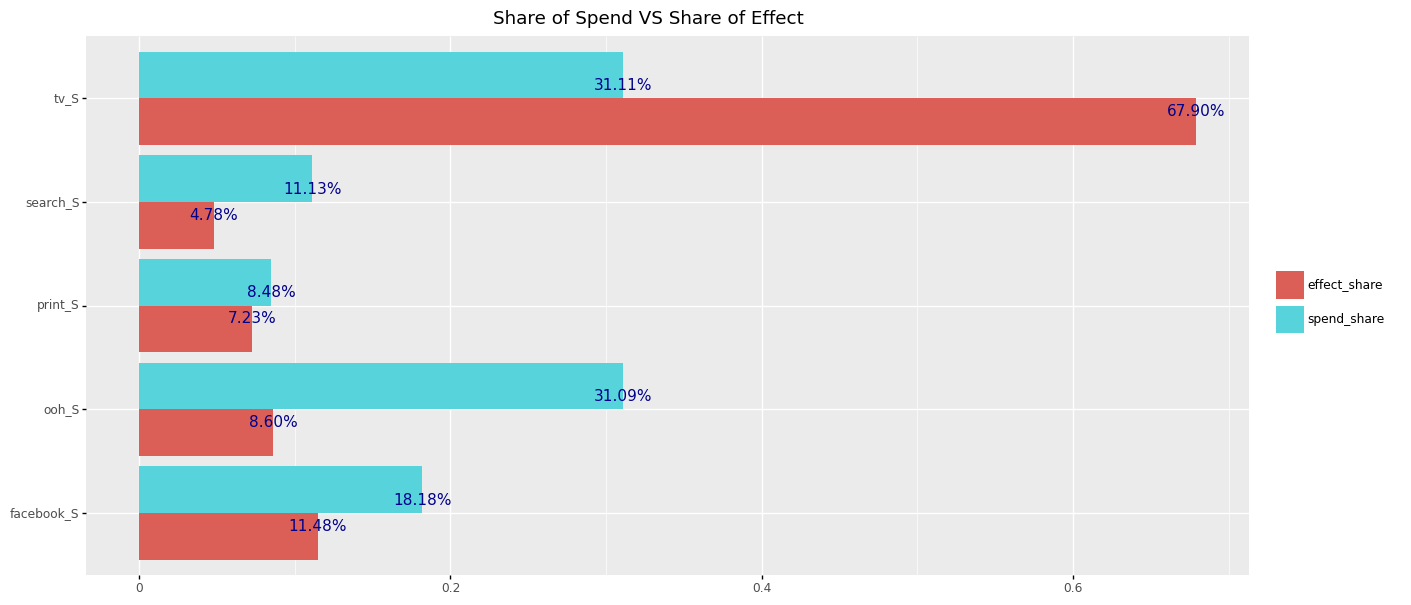


applying geometric adstock transformation on tv_S with alpha 0.510712275296249
applying geometric adstock transformation on ooh_S with alpha 0.3887945244033776
applying geometric adstock transformation on print_S with alpha 0.22563115746762197
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.12268588332428096
applying geometric adstock transformation on newsletter with alpha 0.15597010721539173
predicting 92
RMSE: 255976.76766240815
MAPE: 0.07859151162715497
NRMSE: 0.08307566932960878
R2: 0.8836514850216068

DECOMP.RSSD: 0.24288169067695298


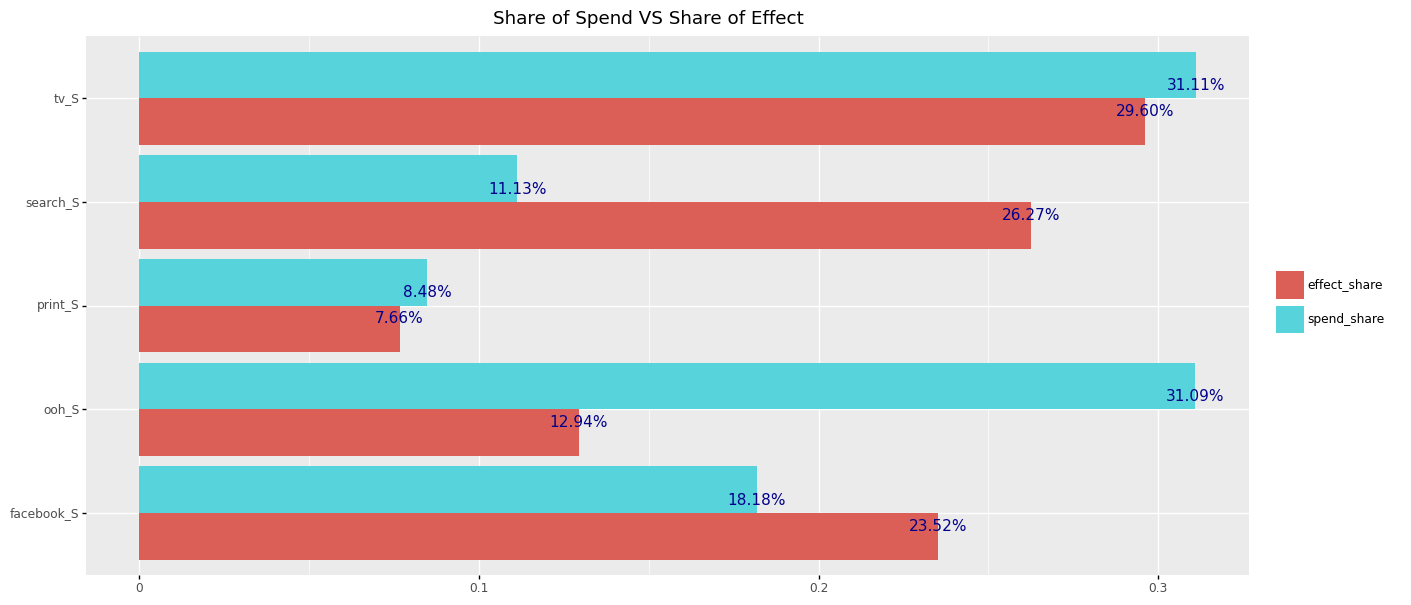


applying geometric adstock transformation on tv_S with alpha 0.510712275296249
applying geometric adstock transformation on ooh_S with alpha 0.3284858845986153
applying geometric adstock transformation on print_S with alpha 0.22563115746762197
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.19558837785078015
applying geometric adstock transformation on newsletter with alpha 0.24238926272494418
predicting 92
RMSE: 82048.81790725236
MAPE: 0.027893186920425285
NRMSE: 0.026628434008267983
R2: 0.9880462436357812

DECOMP.RSSD: 0.4343699392343288


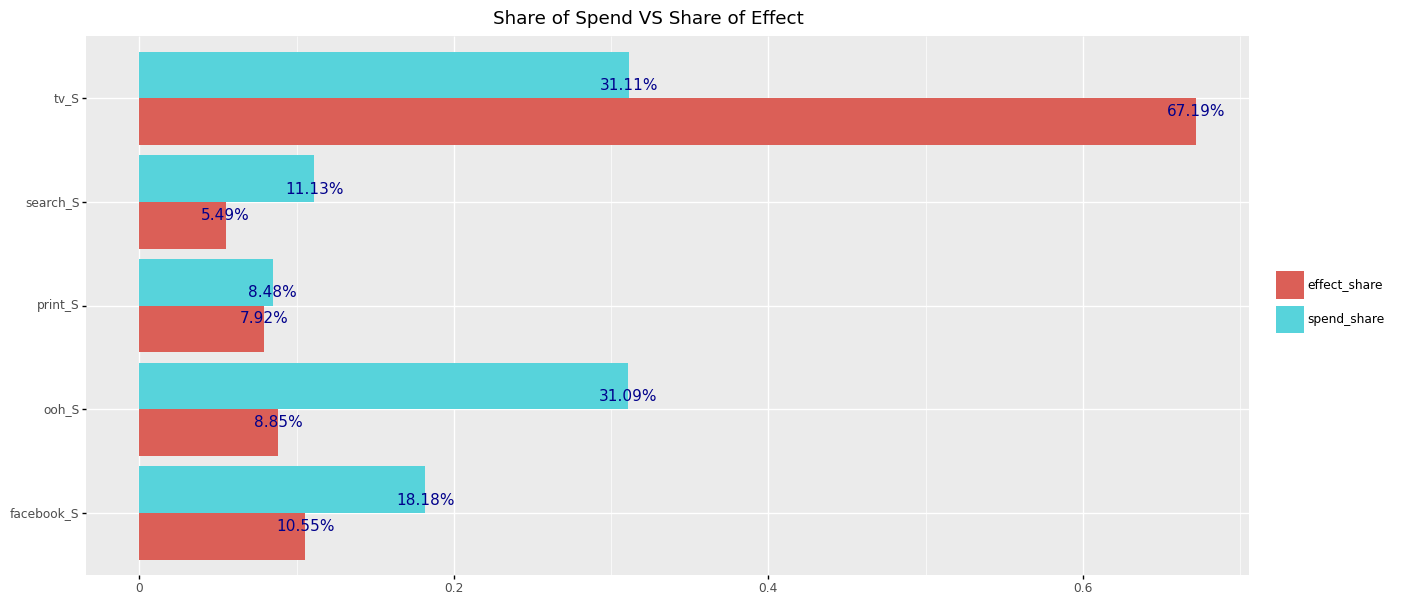


applying geometric adstock transformation on tv_S with alpha 0.53279900906623
applying geometric adstock transformation on ooh_S with alpha 0.3284858845986153
applying geometric adstock transformation on print_S with alpha 0.3507940361536618
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.12268588332428096
applying geometric adstock transformation on newsletter with alpha 0.2703835691657889
predicting 92
RMSE: 239945.94076851563
MAPE: 0.0731462336804779
NRMSE: 0.07787296407522568
R2: 0.8977680705176206

DECOMP.RSSD: 0.306573616594868


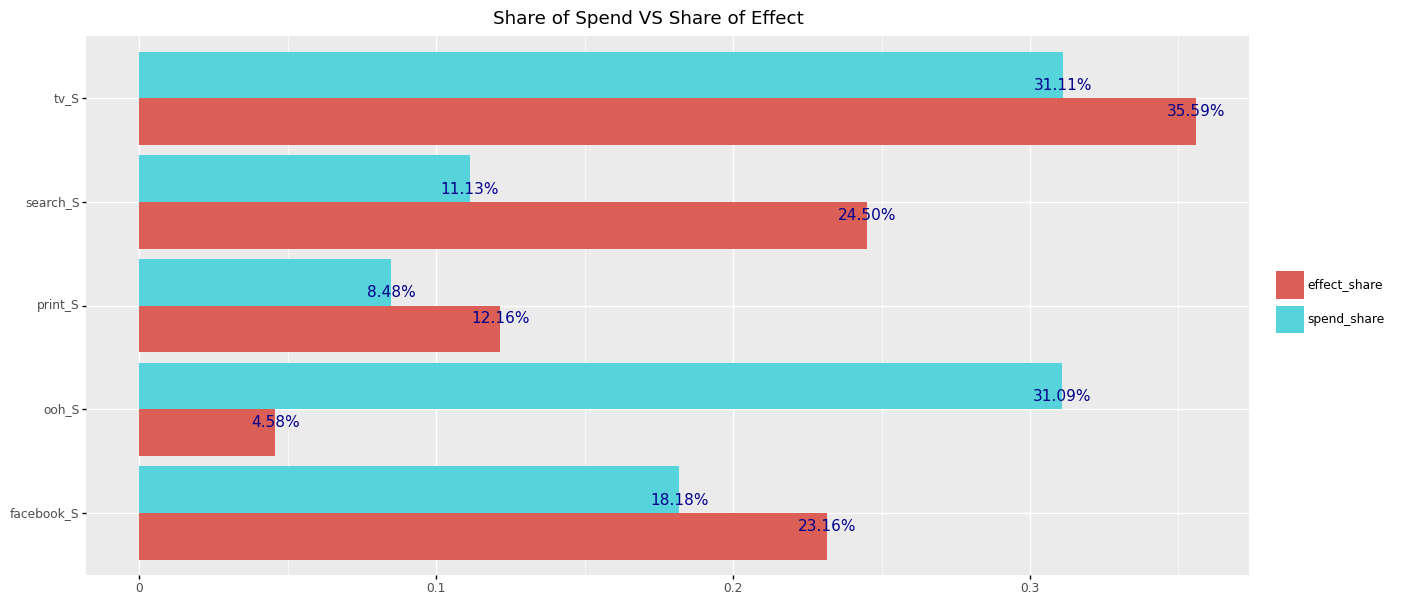


applying geometric adstock transformation on tv_S with alpha 0.49827139116063507
applying geometric adstock transformation on ooh_S with alpha 0.2866260100683621
applying geometric adstock transformation on print_S with alpha 0.3507940361536618
applying geometric adstock transformation on facebook_S with alpha 0.37473189572990323
applying geometric adstock transformation on search_S with alpha 0.12268588332428096
applying geometric adstock transformation on newsletter with alpha 0.2703835691657889
predicting 92
RMSE: 210752.5862897616
MAPE: 0.06283929783815195
NRMSE: 0.06839844228386707
R2: 0.9211311390275965

DECOMP.RSSD: 0.2436608492224564


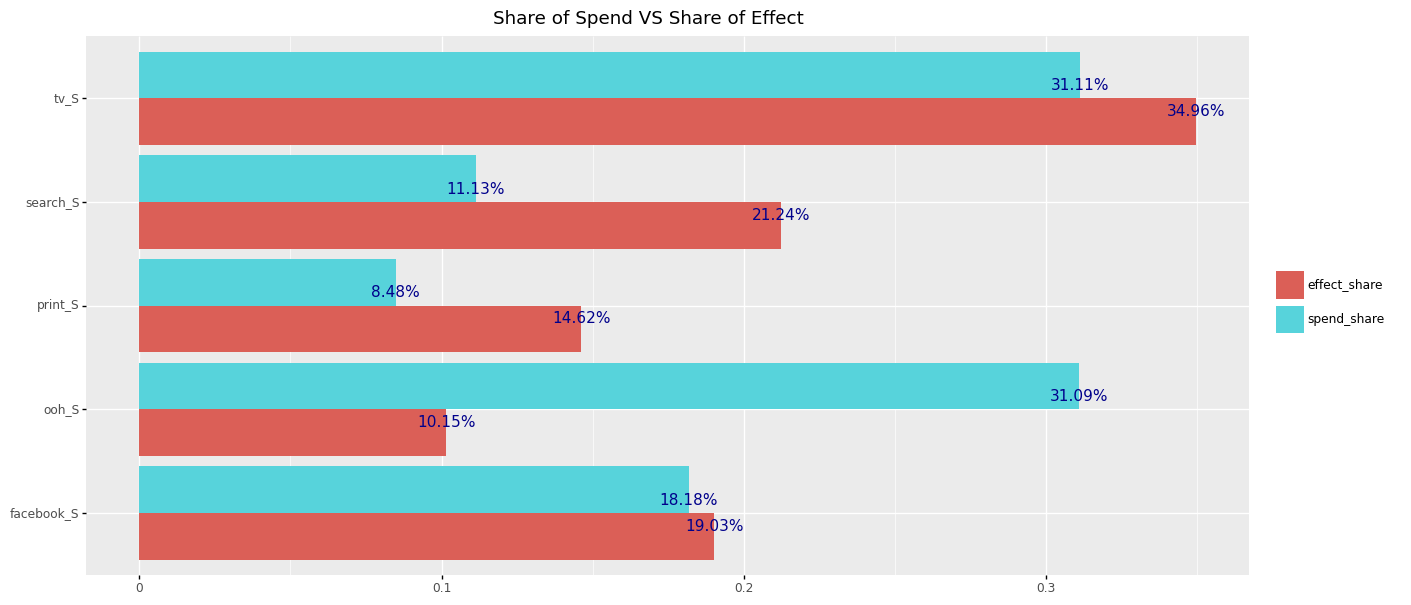


applying geometric adstock transformation on tv_S with alpha 0.48713539787806015
applying geometric adstock transformation on ooh_S with alpha 0.38974664834596606
applying geometric adstock transformation on print_S with alpha 0.22974936349903963
applying geometric adstock transformation on facebook_S with alpha 0.2783896824374792
applying geometric adstock transformation on search_S with alpha 0.07106116769234462
applying geometric adstock transformation on newsletter with alpha 0.2703835691657889
predicting 92
RMSE: 233990.5225014059
MAPE: 0.07038957630352956
NRMSE: 0.07594017008303645
R2: 0.9027798520915715

DECOMP.RSSD: 0.2750889197953209


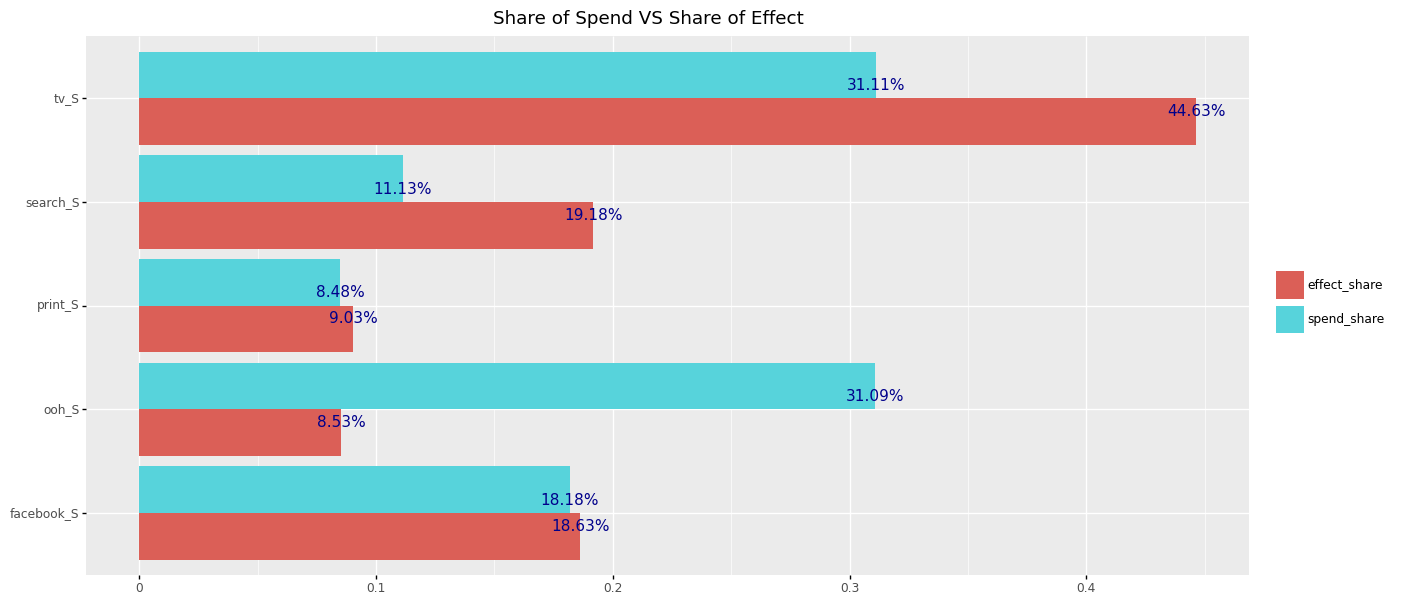

In [46]:
multi_results = []
for trial in experiment_multi.best_trials:
    multi_result = model_refit(data = data, 
                     target = target,
                     features = features, 
                     media_channels = media_channels, 
                     organic_channels = organic_channels, 
                     model_params = trial.user_attrs["params"], 
                     adstock_params = trial.user_attrs["adstock_alphas"], 
                     start_index = START_ANALYSIS_INDEX, 
                     end_index = END_ANALYSIS_INDEX)
    
    print(f'RMSE: {mean_squared_error(y_true = multi_result["y_true_interval"], y_pred = multi_result["prediction_interval"], squared=False)}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true = multi_result["y_true_interval"], y_pred = multi_result["prediction_interval"])}')
    print(f'NRMSE: {nrmse(multi_result["y_true_interval"], multi_result["prediction_interval"])}')
    print(f'R2: {r2_score(y_true = multi_result["y_true_interval"], y_pred = multi_result["prediction_interval"])}')
    print("")
    
    spend_effect_share_multi = calculate_spend_effect_share(df_shap_values = multi_result["df_shap_values"], media_channels = media_channels, df_original = multi_result["x_input_interval_nontransformed"])
    decomp_rssd_multi = rssd(effect_share = spend_effect_share_multi.effect_share.values, spend_share = spend_effect_share_multi.spend_share.values)
    print(f"DECOMP.RSSD: {decomp_rssd_multi}")
    print(plot_spend_vs_effect_share(spend_effect_share_multi, figure_size = (15, 7)))

    multi_results.append(multi_result)

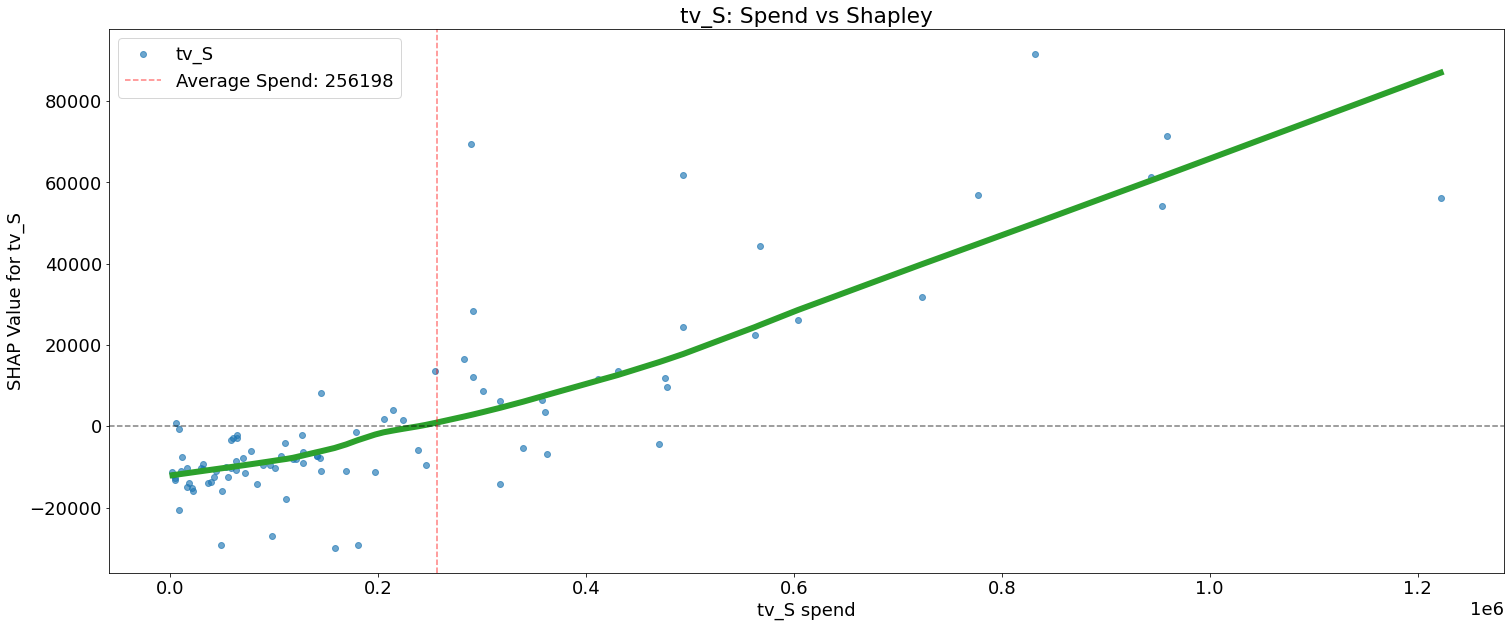

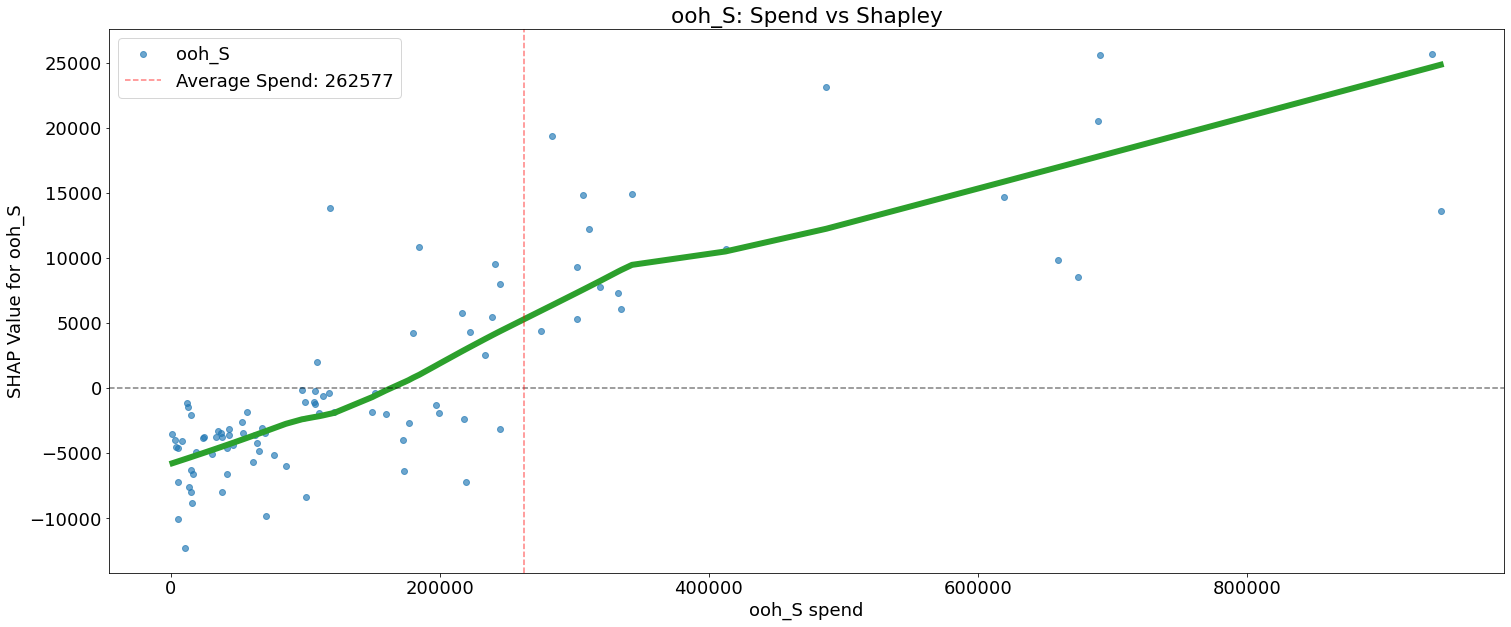

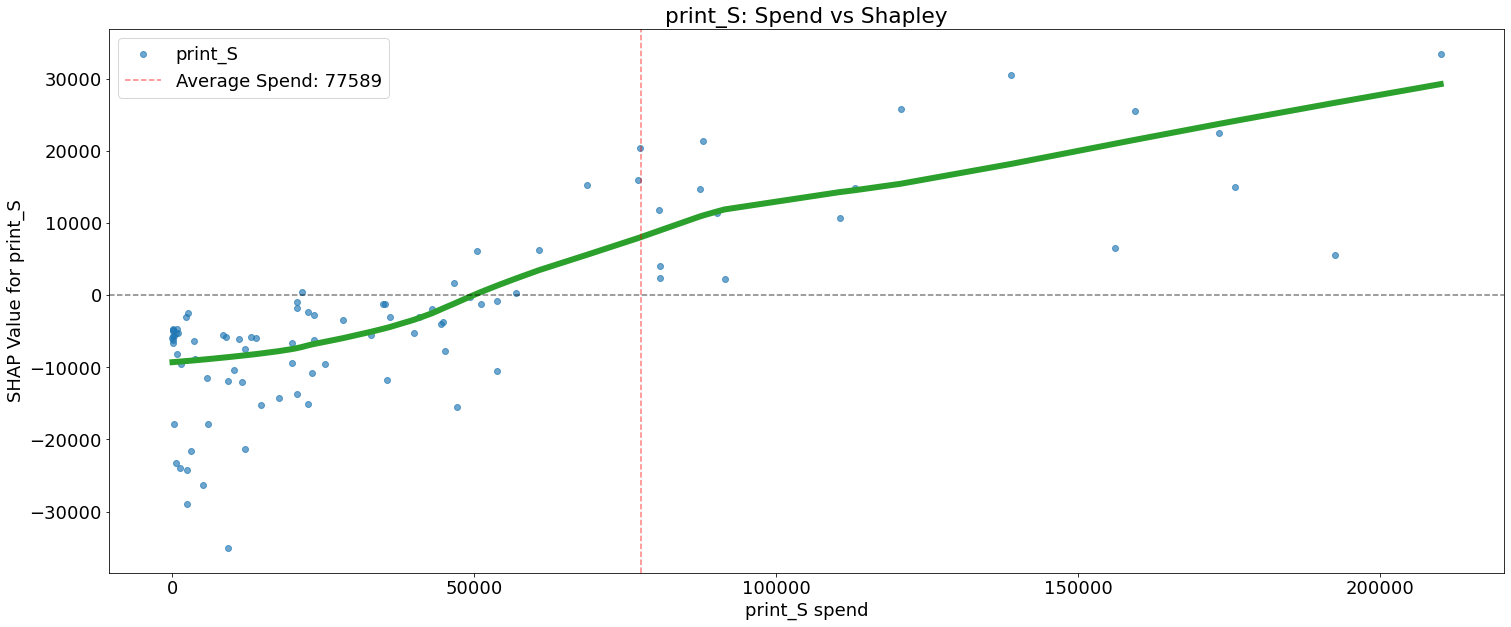

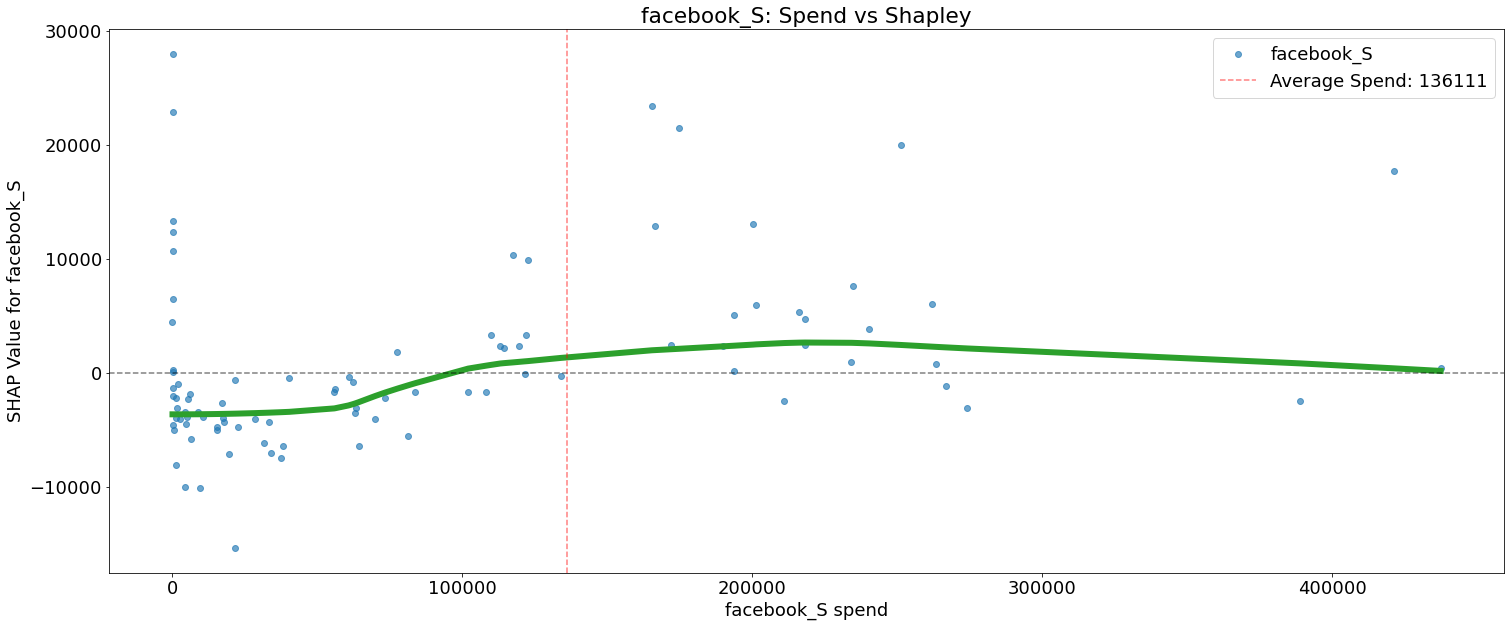

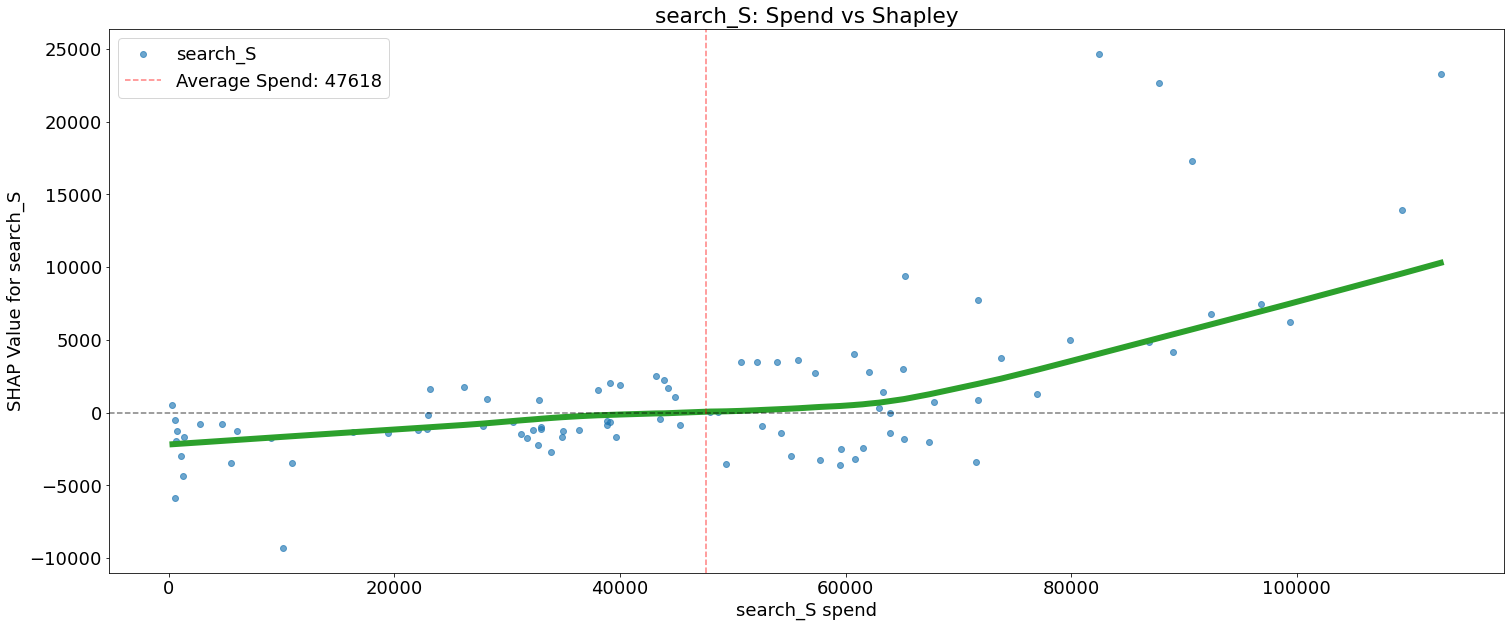

In [47]:
#just take a single best model from pareto front
plot_shap_vs_spend(multi_results[0]["df_shap_values"], multi_results[0]["x_input_interval_nontransformed"], multi_results[0]["x_input_interval_transformed"], features, media_channels)